In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '../data/extracted_features/combined_NLP/harvey/'

NUM_TESTS = 100

HIDDEN_DIM0 = 492
NUM_LAYERS0 = 2
BIDIRECTIONAL = False
LEARNING_RATE0 =  0.06594170753730186
MOMENTUM0= 0.4155718228778864
DECAY_FACTOR0 = 0.9994799511941715
EPOCH0 = 1

HIDDEN_DIM1 = 317
NUM_LAYERS1 = 2
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.01716338255295094
MOMENTUM1= 0.4076566580373683
DECAY_FACTOR1 = 0.6449016801935564
EPOCH1 = 3

HIDDEN_DIM2 = 445
NUM_LAYERS2 = 2
ACTIVATION2 = torch.tanh
LEARNING_RATE2 =  0.007982950726461421
MOMENTUM2= 0.6406284219061565
DECAY_FACTOR2 =  0.22136475950392637
EPOCH2 = 3

# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('STARTING ****************************************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, num_layers = NUM_LAYERS0,
                          bidirectional = BIDIRECTIONAL, learning_rate = LEARNING_RATE0,
                          momentum = MOMENTUM0, decay_factor = DECAY_FACTOR0)
        model.learn(X_train, y_train, epochs=EPOCH0)
        
        # evaluate
        running_acc += model.get_accuracy(X_test, y_test)
        running_auc += model.get_auc(X_test, y_test)
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #model.plot_CIs(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [4]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]


# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


STARTING **************************************************** 0
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


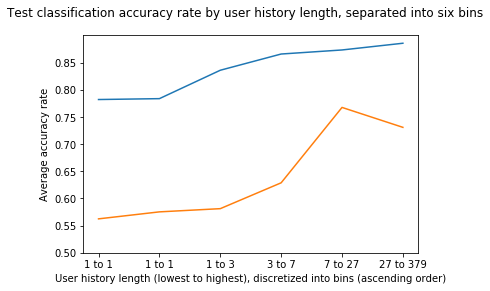

STARTING **************************************************** 1
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


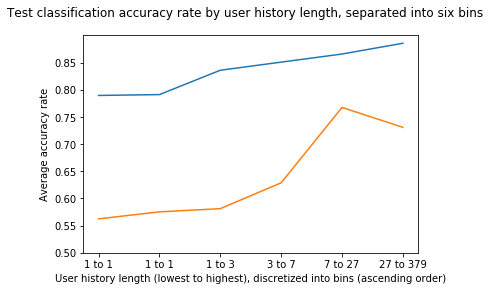

STARTING **************************************************** 2
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


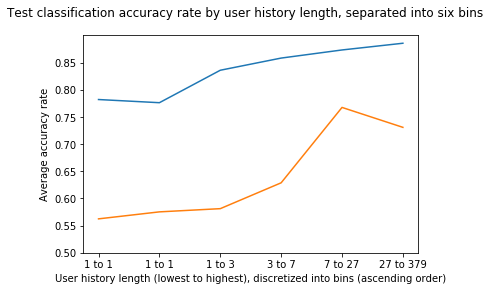

STARTING **************************************************** 3
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


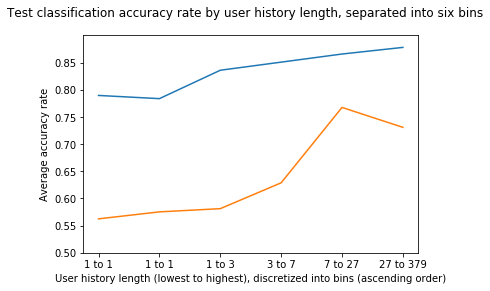

STARTING **************************************************** 4
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


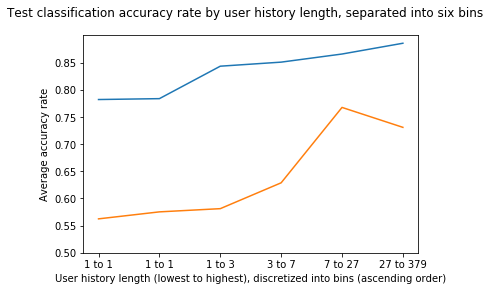

STARTING **************************************************** 5
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


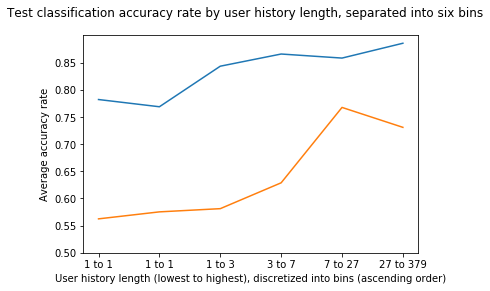

STARTING **************************************************** 6
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


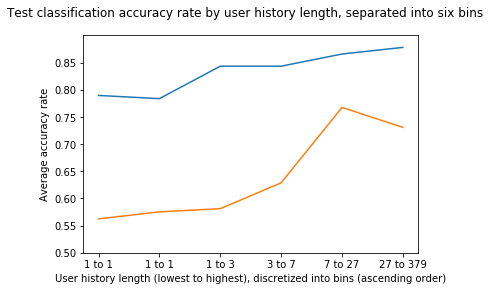

STARTING **************************************************** 7
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


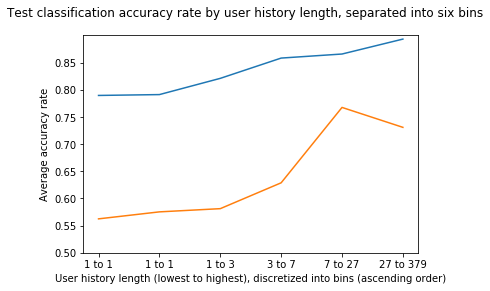

STARTING **************************************************** 8
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


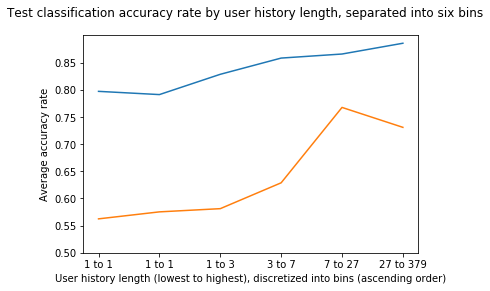

STARTING **************************************************** 9
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


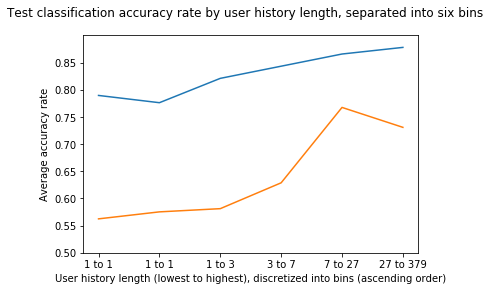

STARTING **************************************************** 10
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


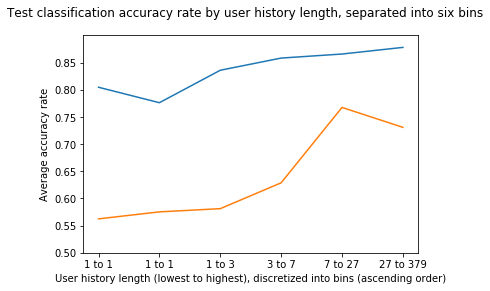

STARTING **************************************************** 11
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


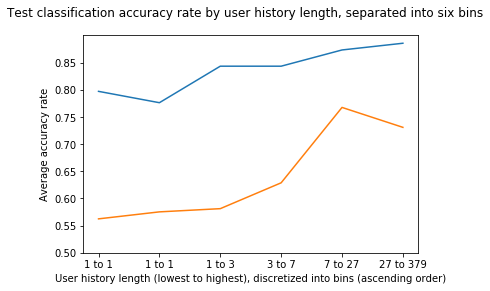

STARTING **************************************************** 12
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


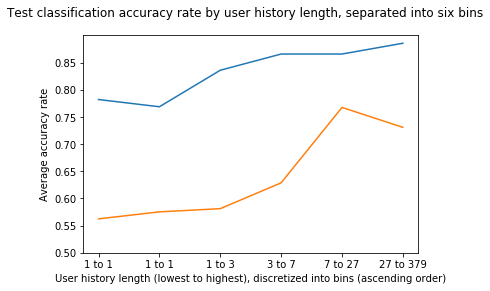

STARTING **************************************************** 13
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 14
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


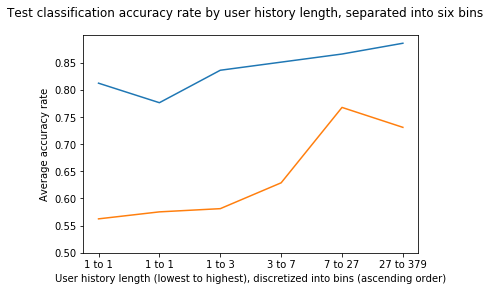

STARTING **************************************************** 15
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 16
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 17
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


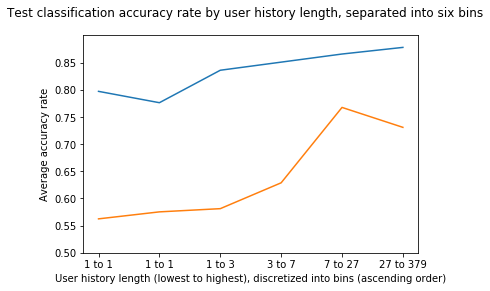

STARTING **************************************************** 18
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


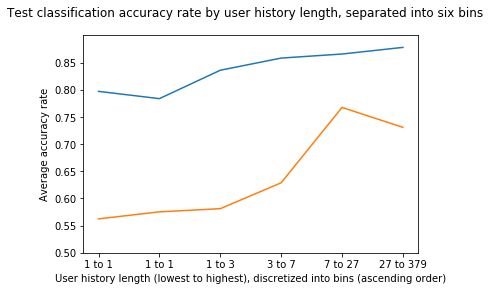

STARTING **************************************************** 19
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 20
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


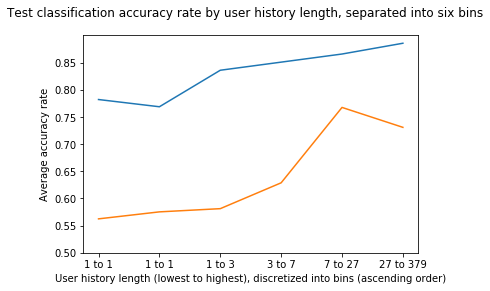

STARTING **************************************************** 21
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


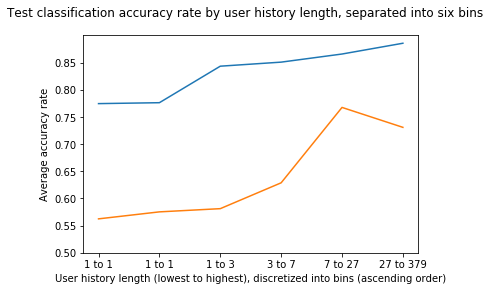

STARTING **************************************************** 22
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


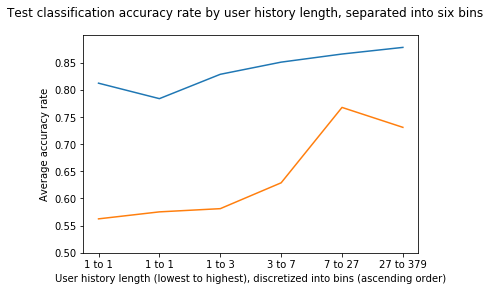

STARTING **************************************************** 23
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


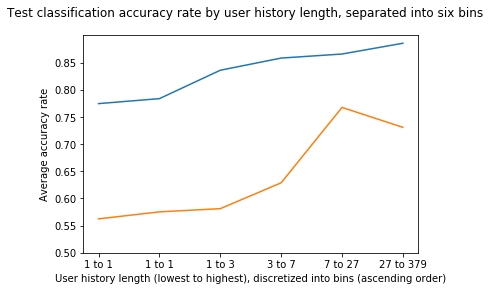

STARTING **************************************************** 24
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 25
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


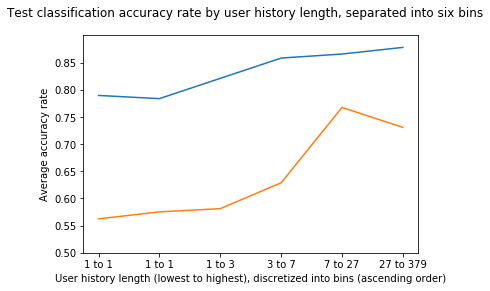

STARTING **************************************************** 26
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


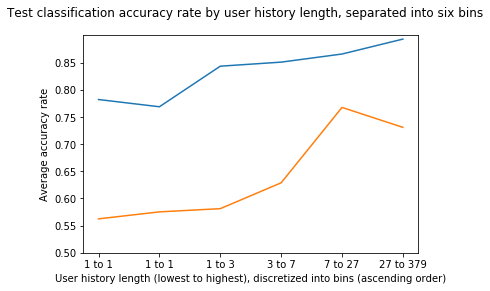

STARTING **************************************************** 27
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 28
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


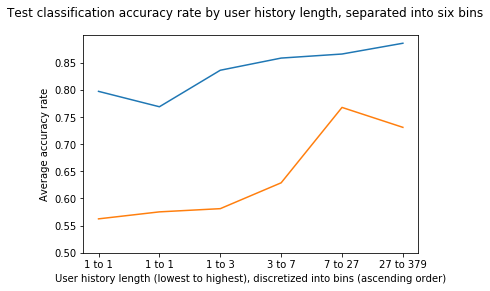

STARTING **************************************************** 29
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 30
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


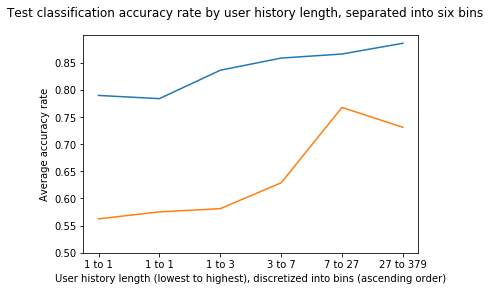

STARTING **************************************************** 31
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


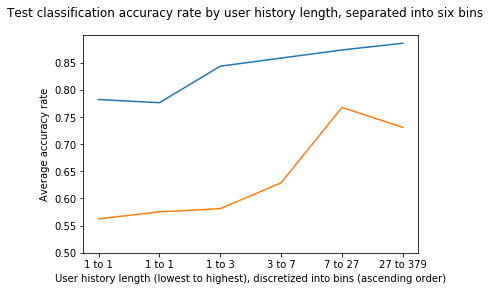

STARTING **************************************************** 32
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


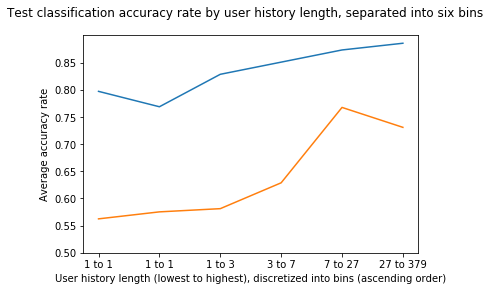

STARTING **************************************************** 33
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 34
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 35
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 36
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


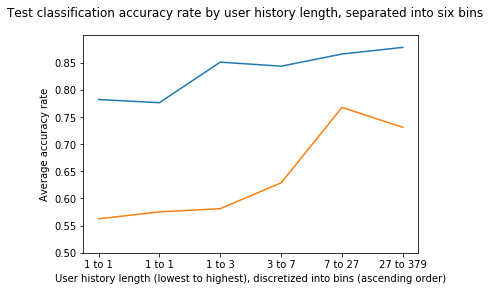

STARTING **************************************************** 37
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


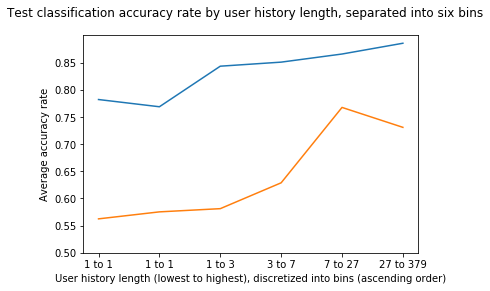

STARTING **************************************************** 38
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


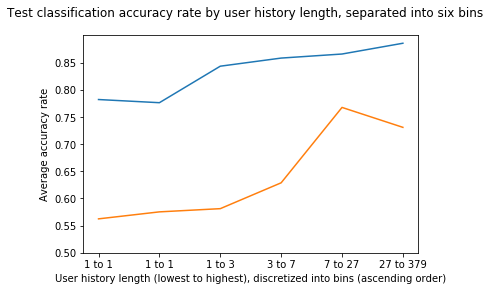

STARTING **************************************************** 39
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


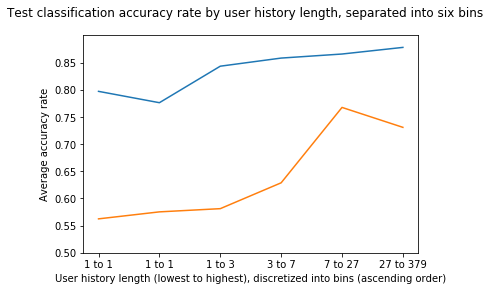

STARTING **************************************************** 40
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


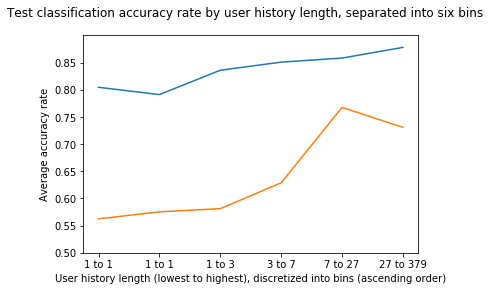

STARTING **************************************************** 41
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 42
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


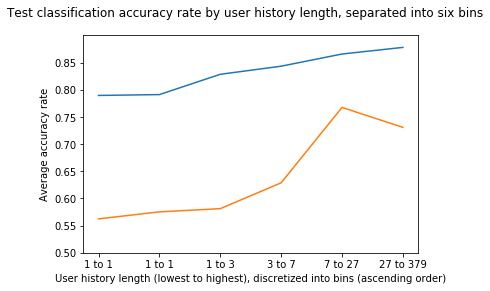

STARTING **************************************************** 43
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


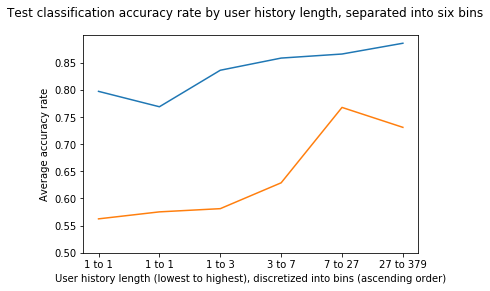

STARTING **************************************************** 44
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


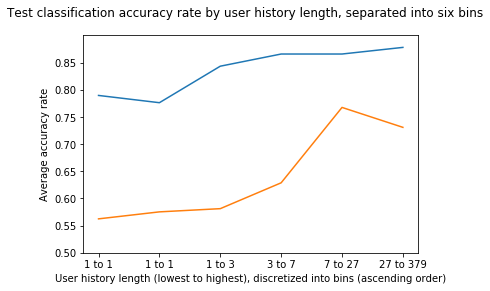

STARTING **************************************************** 45
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


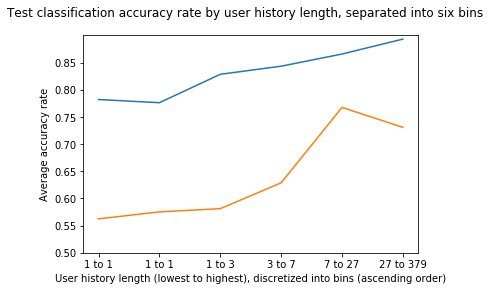

STARTING **************************************************** 46
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 47
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 48
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


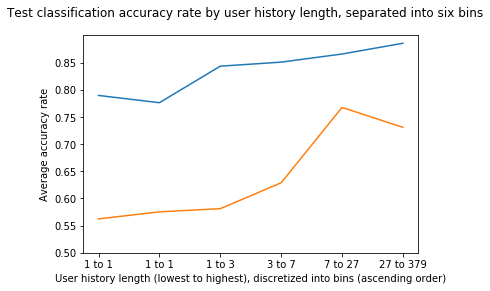

STARTING **************************************************** 49
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


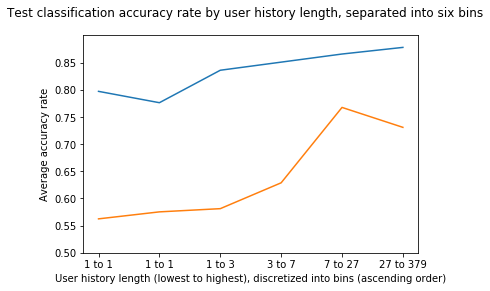

STARTING **************************************************** 50
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


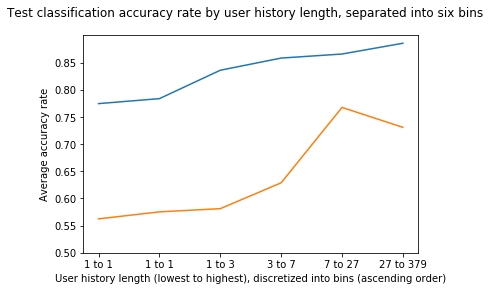

STARTING **************************************************** 51
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


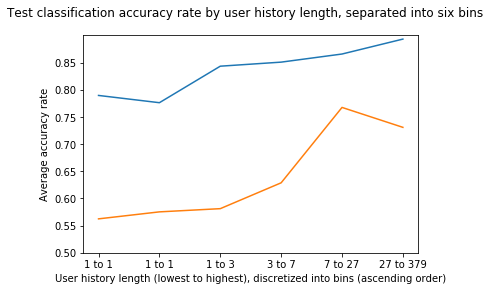

STARTING **************************************************** 52
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


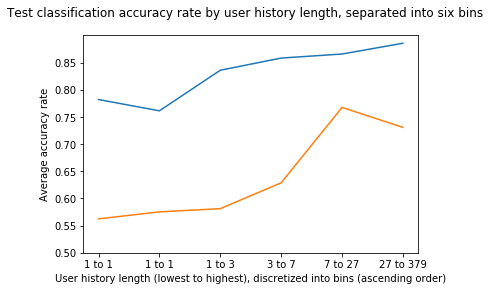

STARTING **************************************************** 53
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


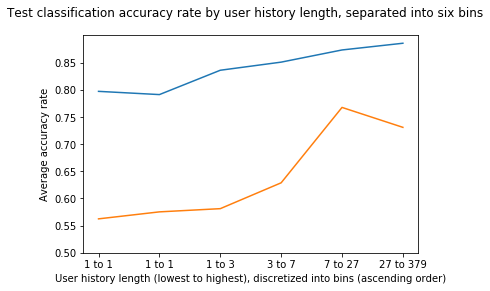

STARTING **************************************************** 54
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


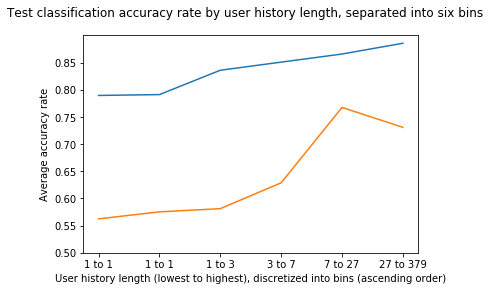

STARTING **************************************************** 55
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 56
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


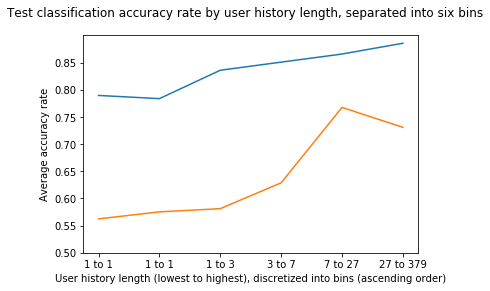

STARTING **************************************************** 57
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


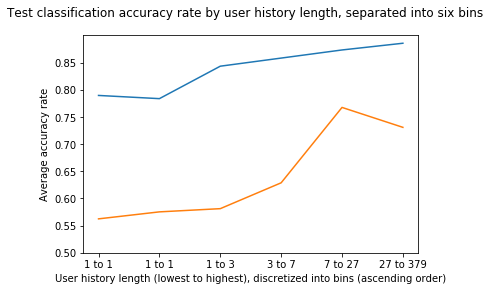

STARTING **************************************************** 58
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 59
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


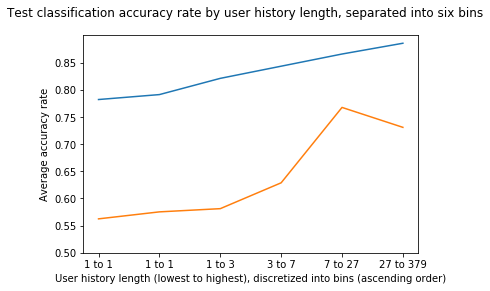

STARTING **************************************************** 60
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


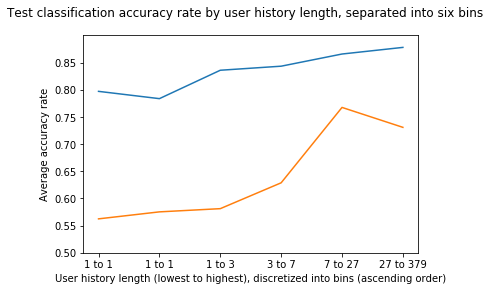

STARTING **************************************************** 61
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


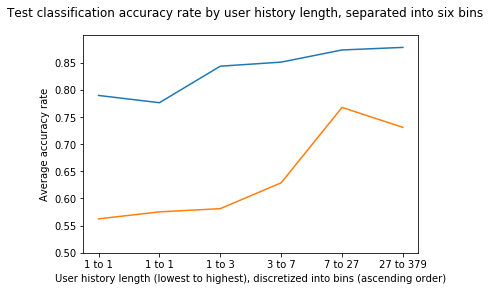

STARTING **************************************************** 62
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


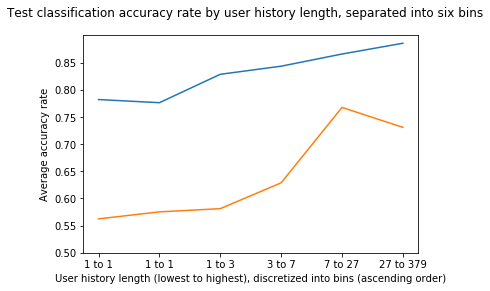

STARTING **************************************************** 63
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 64
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 65
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


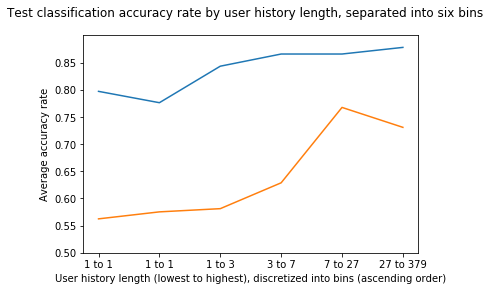

STARTING **************************************************** 66
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


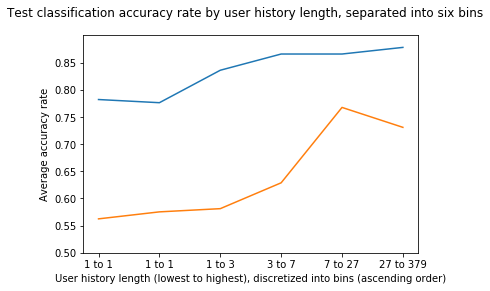

STARTING **************************************************** 67
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


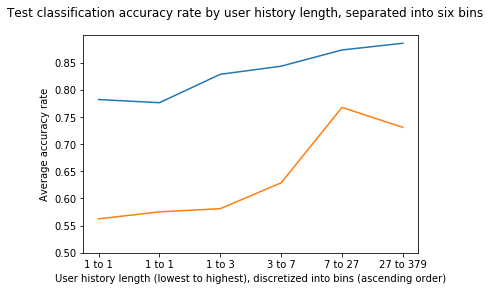

STARTING **************************************************** 68
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


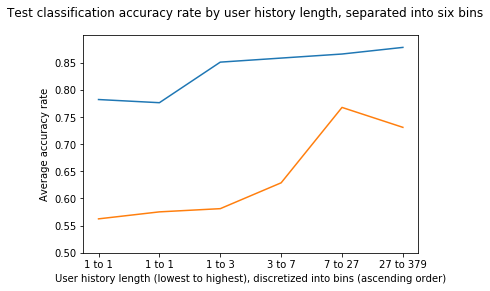

STARTING **************************************************** 69
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


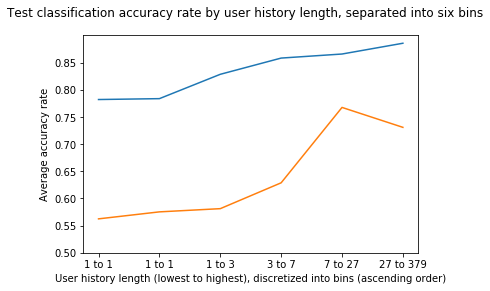

STARTING **************************************************** 70
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


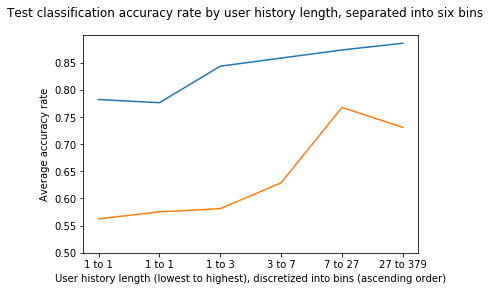

STARTING **************************************************** 71
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


STARTING **************************************************** 72
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


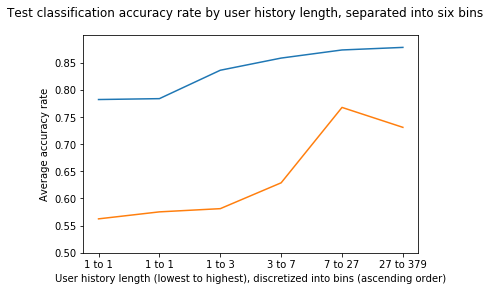

STARTING **************************************************** 73
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


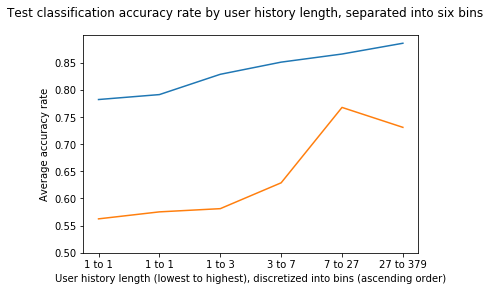

STARTING **************************************************** 74
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


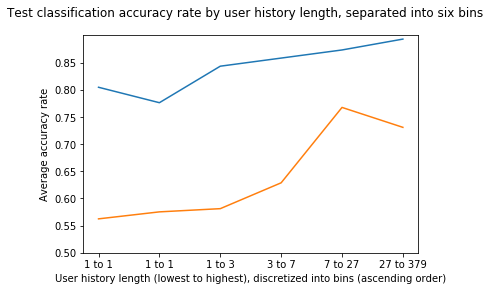

STARTING **************************************************** 75
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


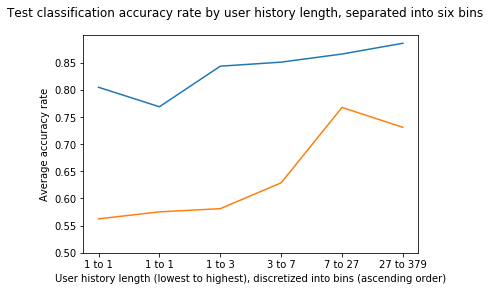

STARTING **************************************************** 76
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


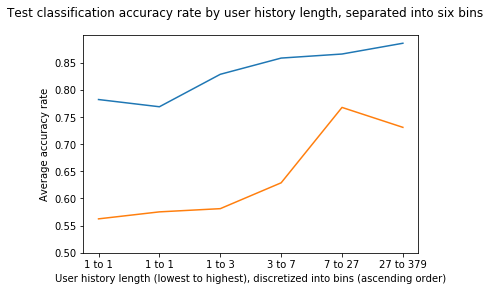

STARTING **************************************************** 77
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


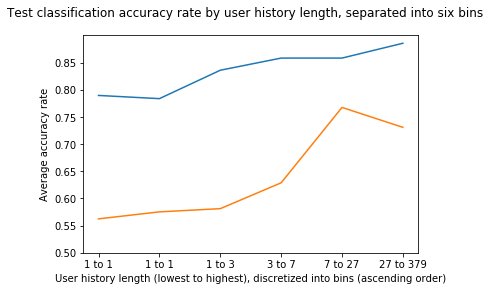

STARTING **************************************************** 78
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


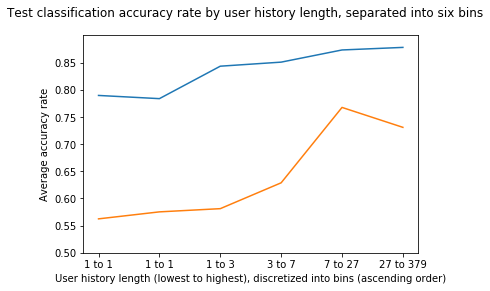

STARTING **************************************************** 79
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


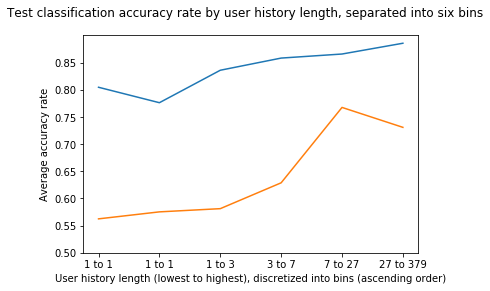

STARTING **************************************************** 80
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


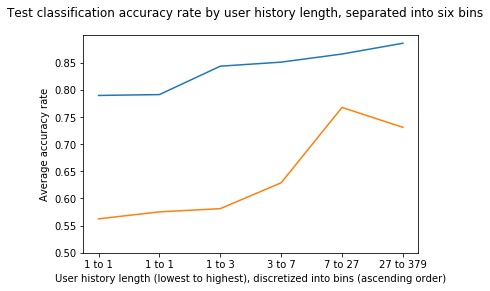

STARTING **************************************************** 81
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


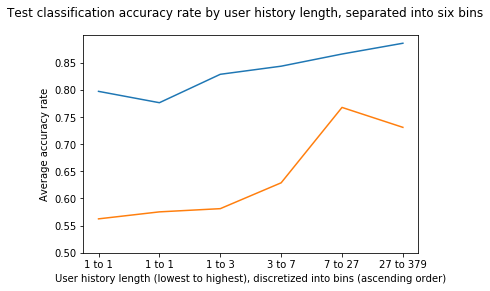

STARTING **************************************************** 82
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


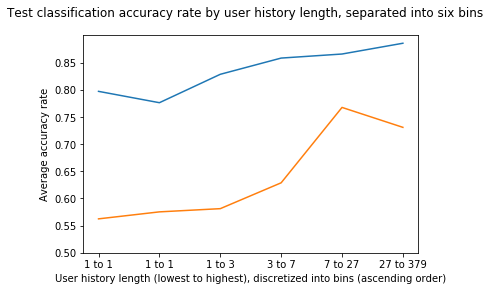

STARTING **************************************************** 83
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


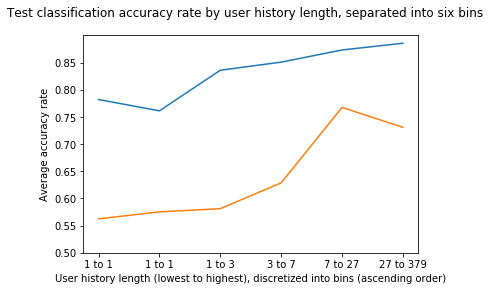

STARTING **************************************************** 84
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


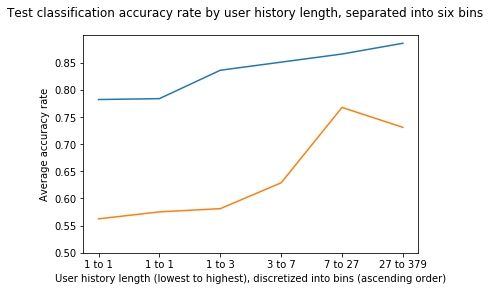

STARTING **************************************************** 85
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


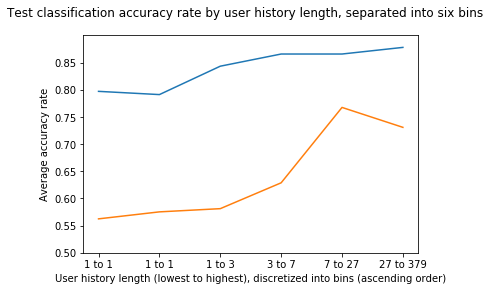

STARTING **************************************************** 86
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


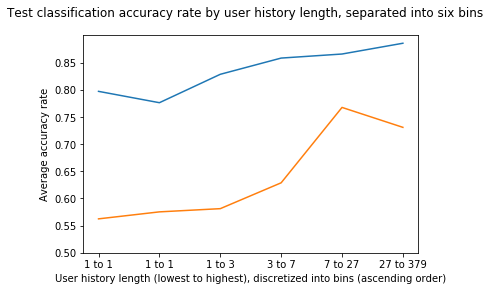

STARTING **************************************************** 87
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


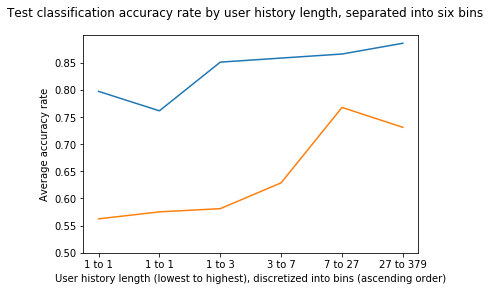

STARTING **************************************************** 88
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


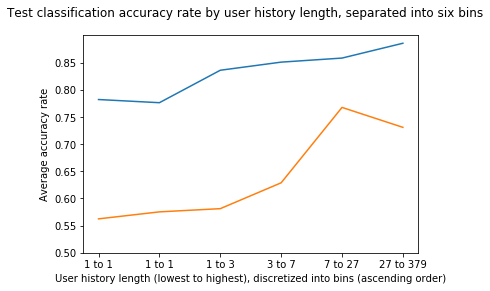

STARTING **************************************************** 89
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


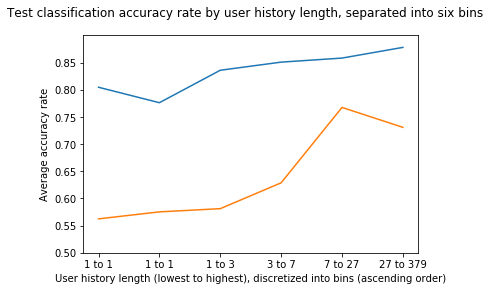

STARTING **************************************************** 90
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


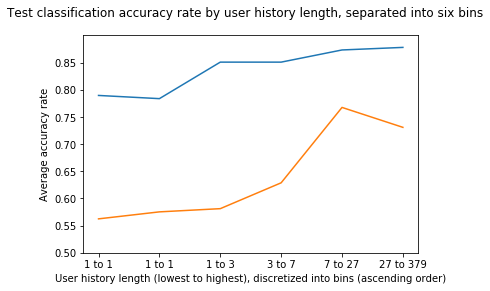

STARTING **************************************************** 91
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


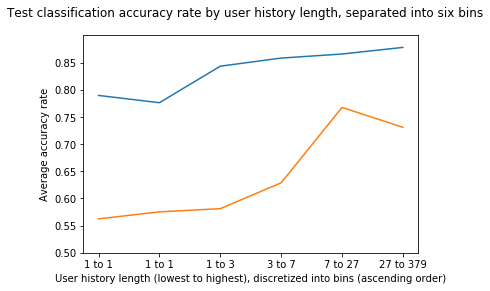

STARTING **************************************************** 92
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


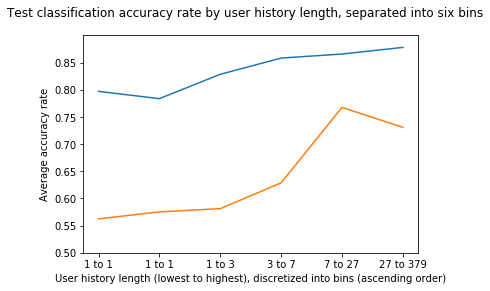

STARTING **************************************************** 93
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


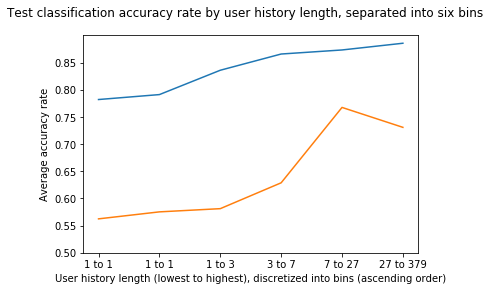

STARTING **************************************************** 94
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


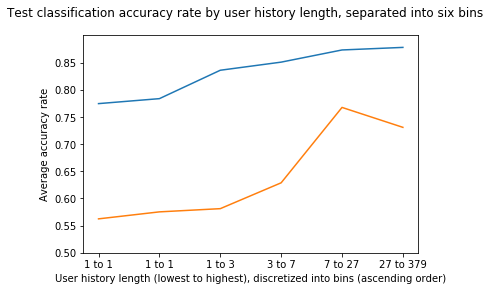

STARTING **************************************************** 95
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


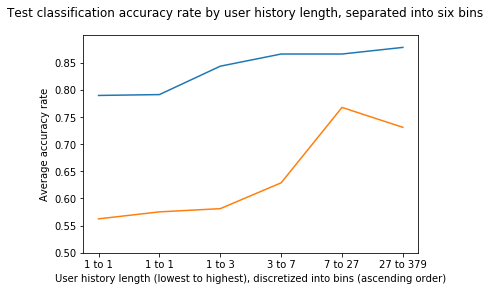

STARTING **************************************************** 96
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


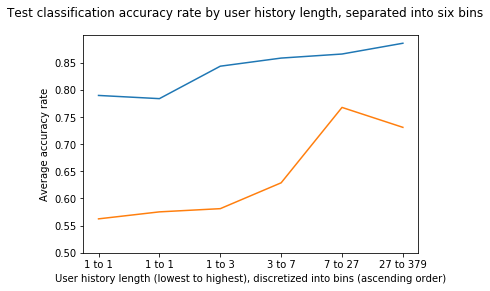

STARTING **************************************************** 97
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


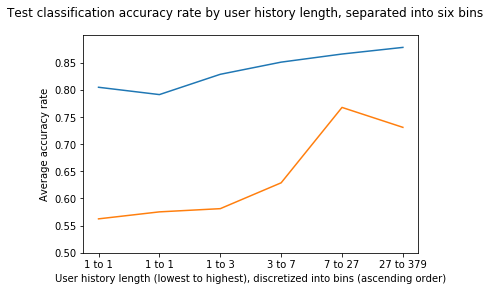

STARTING **************************************************** 98
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


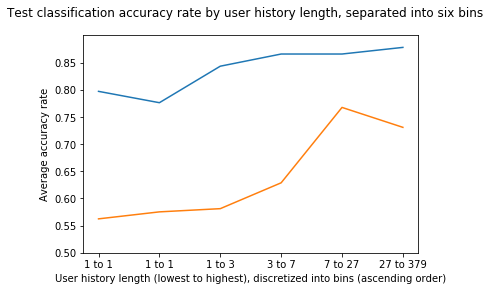

STARTING **************************************************** 99
epoch: 0 learning rate: [0.06594170753730186]
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


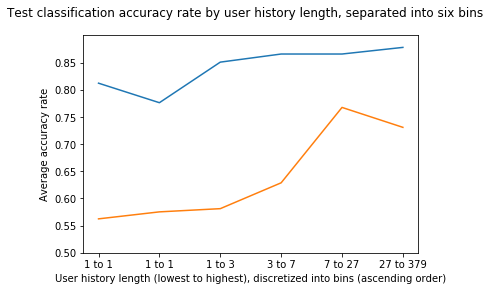

In [5]:


acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

0.834975
0.8410359930395996


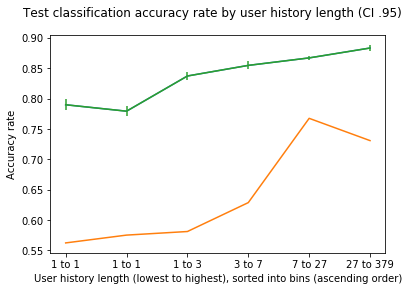

In [6]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    for i in range(NUM_TESTS):
        print('STARTING ****************************************************', i)

        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        running_acc += baseline.get_accuracy(torch.Tensor(X_test), torch.Tensor(y_test))
        running_auc += baseline.get_auc(torch.Tensor(X_test), torch.Tensor(y_test))
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test), X_hist_len_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_seq_tfidf_test = np.load(TFIDF_DIR + 'X_seq_tfidf_test.npz')
X_hist_len_test = [ torch.Tensor(X_seq_tfidf_test[file]).shape[0] for file in X_seq_tfidf_test.files]


# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train_glove = np.load(GLOVE_DIR + 'y_train.npy')
y_test_glove = np.load(GLOVE_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove


STARTING **************************************************** 0
epoch: 0 learning rate: [0.01716338255295094]
[1,   200] loss: 0.567
[1,   400] loss: 0.496
[1,   600] loss: 0.465
[1,   800] loss: 0.463
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.372
[2,   400] loss: 0.366
[2,   600] loss: 0.382
[2,   800] loss: 0.343
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.308
[3,   600] loss: 0.284
[3,   800] loss: 0.300
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.86

[1,   200] loss: 0.583
[1,   400] loss: 0.525
[1,   600] loss: 0.444
[1,   800] loss: 0.404
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.373
[2,   400] loss: 0.341
[2,   600] loss: 0.331
[2,   800] loss: 0.367
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.287
[3,   400] loss: 0.250
[3,   600] loss: 0.310
[3,   800] loss: 0.292
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *****************************

[1,   200] loss: 0.570
[1,   400] loss: 0.513
[1,   600] loss: 0.472
[1,   800] loss: 0.424
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.372
[2,   400] loss: 0.362
[2,   600] loss: 0.334
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.294
[3,   400] loss: 0.297
[3,   600] loss: 0.280
[3,   800] loss: 0.285
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.564
[1,   400] loss: 0.494
[1,   600] loss: 0.460
[1,   800] loss: 0.452
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.396
[2,   400] loss: 0.355
[2,   600] loss: 0.335
[2,   800] loss: 0.331
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.277
[3,   600] loss: 0.304
[3,   800] loss: 0.283
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.563
[1,   400] loss: 0.529
[1,   600] loss: 0.455
[1,   800] loss: 0.415
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.374
[2,   400] loss: 0.354
[2,   600] loss: 0.353
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.306
[3,   400] loss: 0.294
[3,   600] loss: 0.289
[3,   800] loss: 0.266
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.564
[1,   400] loss: 0.537
[1,   600] loss: 0.437
[1,   800] loss: 0.434
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.382
[2,   400] loss: 0.362
[2,   600] loss: 0.363
[2,   800] loss: 0.330
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.301
[3,   400] loss: 0.294
[3,   600] loss: 0.286
[3,   800] loss: 0.275
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.571
[1,   400] loss: 0.501
[1,   600] loss: 0.482
[1,   800] loss: 0.448
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.370
[2,   400] loss: 0.359
[2,   600] loss: 0.353
[2,   800] loss: 0.364
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.291
[3,   400] loss: 0.291
[3,   600] loss: 0.297
[3,   800] loss: 0.303
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.567
[1,   400] loss: 0.479
[1,   600] loss: 0.467
[1,   800] loss: 0.423
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.361
[2,   400] loss: 0.346
[2,   600] loss: 0.334
[2,   800] loss: 0.347
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.268
[3,   400] loss: 0.292
[3,   600] loss: 0.315
[3,   800] loss: 0.259
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.563
[1,   400] loss: 0.508
[1,   600] loss: 0.490
[1,   800] loss: 0.408
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.359
[2,   400] loss: 0.345
[2,   600] loss: 0.359
[2,   800] loss: 0.344
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.306
[3,   400] loss: 0.279
[3,   600] loss: 0.263
[3,   800] loss: 0.291
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.574
[1,   400] loss: 0.513
[1,   600] loss: 0.488
[1,   800] loss: 0.424
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.371
[2,   400] loss: 0.382
[2,   600] loss: 0.349
[2,   800] loss: 0.360
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.292
[3,   400] loss: 0.293
[3,   600] loss: 0.291
[3,   800] loss: 0.304
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.588
[1,   400] loss: 0.526
[1,   600] loss: 0.466
[1,   800] loss: 0.410
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.371
[2,   400] loss: 0.359
[2,   600] loss: 0.353
[2,   800] loss: 0.364
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.298
[3,   400] loss: 0.286
[3,   600] loss: 0.278
[3,   800] loss: 0.300
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.591
[1,   400] loss: 0.480
[1,   600] loss: 0.469
[1,   800] loss: 0.422
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.355
[2,   400] loss: 0.375
[2,   600] loss: 0.336
[2,   800] loss: 0.351
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.283
[3,   400] loss: 0.282
[3,   600] loss: 0.271
[3,   800] loss: 0.301
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.571
[1,   400] loss: 0.504
[1,   600] loss: 0.468
[1,   800] loss: 0.431
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.377
[2,   400] loss: 0.370
[2,   600] loss: 0.358
[2,   800] loss: 0.363
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.308
[3,   400] loss: 0.292
[3,   600] loss: 0.312
[3,   800] loss: 0.274
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.567
[1,   400] loss: 0.520
[1,   600] loss: 0.472
[1,   800] loss: 0.439
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.396
[2,   400] loss: 0.380
[2,   600] loss: 0.332
[2,   800] loss: 0.345
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.302
[3,   400] loss: 0.279
[3,   600] loss: 0.295
[3,   800] loss: 0.306
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.520
[1,   600] loss: 0.470
[1,   800] loss: 0.407
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.364
[2,   400] loss: 0.350
[2,   600] loss: 0.367
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.276
[3,   400] loss: 0.279
[3,   600] loss: 0.297
[3,   800] loss: 0.291
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.547
[1,   400] loss: 0.516
[1,   600] loss: 0.459
[1,   800] loss: 0.443
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.381
[2,   400] loss: 0.372
[2,   600] loss: 0.324
[2,   800] loss: 0.347
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.285
[3,   400] loss: 0.285
[3,   600] loss: 0.288
[3,   800] loss: 0.288
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.508
[1,   600] loss: 0.490
[1,   800] loss: 0.432
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.385
[2,   400] loss: 0.373
[2,   600] loss: 0.346
[2,   800] loss: 0.330
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.300
[3,   400] loss: 0.288
[3,   600] loss: 0.289
[3,   800] loss: 0.290
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.583
[1,   400] loss: 0.494
[1,   600] loss: 0.479
[1,   800] loss: 0.424
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.371
[2,   400] loss: 0.365
[2,   600] loss: 0.350
[2,   800] loss: 0.330
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.284
[3,   400] loss: 0.308
[3,   600] loss: 0.265
[3,   800] loss: 0.288
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.572
[1,   400] loss: 0.503
[1,   600] loss: 0.467
[1,   800] loss: 0.412
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.362
[2,   400] loss: 0.336
[2,   600] loss: 0.359
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.284
[3,   400] loss: 0.284
[3,   600] loss: 0.293
[3,   800] loss: 0.272
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.584
[1,   400] loss: 0.520
[1,   600] loss: 0.466
[1,   800] loss: 0.422
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.363
[2,   400] loss: 0.377
[2,   600] loss: 0.353
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.278
[3,   400] loss: 0.310
[3,   600] loss: 0.285
[3,   800] loss: 0.308
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.557
[1,   400] loss: 0.502
[1,   600] loss: 0.511
[1,   800] loss: 0.456
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.388
[2,   400] loss: 0.373
[2,   600] loss: 0.354
[2,   800] loss: 0.359
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.300
[3,   400] loss: 0.300
[3,   600] loss: 0.310
[3,   800] loss: 0.277
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.578
[1,   400] loss: 0.504
[1,   600] loss: 0.448
[1,   800] loss: 0.455
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.363
[2,   400] loss: 0.362
[2,   600] loss: 0.377
[2,   800] loss: 0.326
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.335
[3,   400] loss: 0.304
[3,   600] loss: 0.253
[3,   800] loss: 0.258
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.587
[1,   400] loss: 0.497
[1,   600] loss: 0.465
[1,   800] loss: 0.445
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.401
[2,   400] loss: 0.369
[2,   600] loss: 0.359
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.310
[3,   400] loss: 0.325
[3,   600] loss: 0.272
[3,   800] loss: 0.281
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.580
[1,   400] loss: 0.524
[1,   600] loss: 0.462
[1,   800] loss: 0.444
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.388
[2,   400] loss: 0.366
[2,   600] loss: 0.365
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.298
[3,   400] loss: 0.311
[3,   600] loss: 0.306
[3,   800] loss: 0.276
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.490
[1,   600] loss: 0.484
[1,   800] loss: 0.430
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.380
[2,   400] loss: 0.355
[2,   600] loss: 0.340
[2,   800] loss: 0.358
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.289
[3,   400] loss: 0.296
[3,   600] loss: 0.305
[3,   800] loss: 0.273
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.581
[1,   400] loss: 0.493
[1,   600] loss: 0.463
[1,   800] loss: 0.436
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.382
[2,   400] loss: 0.352
[2,   600] loss: 0.353
[2,   800] loss: 0.337
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.295
[3,   600] loss: 0.279
[3,   800] loss: 0.279
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ******************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.580
[1,   400] loss: 0.524
[1,   600] loss: 0.442
[1,   800] loss: 0.449
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.377
[2,   400] loss: 0.407
[2,   600] loss: 0.363
[2,   800] loss: 0.345
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.314
[3,   400] loss: 0.294
[3,   600] loss: 0.311
[3,   800] loss: 0.296
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.576
[1,   400] loss: 0.482
[1,   600] loss: 0.476
[1,   800] loss: 0.445
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.407
[2,   400] loss: 0.373
[2,   600] loss: 0.338
[2,   800] loss: 0.340
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.307
[3,   400] loss: 0.335
[3,   600] loss: 0.269
[3,   800] loss: 0.258
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.581
[1,   400] loss: 0.478
[1,   600] loss: 0.444
[1,   800] loss: 0.403
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.354
[2,   400] loss: 0.316
[2,   600] loss: 0.318
[2,   800] loss: 0.360
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.297
[3,   400] loss: 0.259
[3,   600] loss: 0.259
[3,   800] loss: 0.272
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.500
[1,   600] loss: 0.459
[1,   800] loss: 0.453
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.378
[2,   400] loss: 0.366
[2,   600] loss: 0.349
[2,   800] loss: 0.352
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.291
[3,   400] loss: 0.283
[3,   600] loss: 0.311
[3,   800] loss: 0.272
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.578
[1,   400] loss: 0.504
[1,   600] loss: 0.478
[1,   800] loss: 0.439
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.392
[2,   400] loss: 0.369
[2,   600] loss: 0.333
[2,   800] loss: 0.359
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.273
[3,   400] loss: 0.311
[3,   600] loss: 0.286
[3,   800] loss: 0.295
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.577
[1,   400] loss: 0.520
[1,   600] loss: 0.488
[1,   800] loss: 0.422
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.399
[2,   400] loss: 0.366
[2,   600] loss: 0.395
[2,   800] loss: 0.318
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.299
[3,   400] loss: 0.288
[3,   600] loss: 0.300
[3,   800] loss: 0.312
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.554
[1,   400] loss: 0.512
[1,   600] loss: 0.455
[1,   800] loss: 0.406
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.376
[2,   400] loss: 0.366
[2,   600] loss: 0.320
[2,   800] loss: 0.324
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.271
[3,   600] loss: 0.312
[3,   800] loss: 0.258
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.532
[1,   400] loss: 0.495
[1,   600] loss: 0.454
[1,   800] loss: 0.452
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.354
[2,   400] loss: 0.333
[2,   600] loss: 0.365
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.293
[3,   400] loss: 0.280
[3,   600] loss: 0.290
[3,   800] loss: 0.263
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.563
[1,   400] loss: 0.489
[1,   600] loss: 0.475
[1,   800] loss: 0.437
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.394
[2,   400] loss: 0.346
[2,   600] loss: 0.367
[2,   800] loss: 0.341
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.280
[3,   400] loss: 0.288
[3,   600] loss: 0.313
[3,   800] loss: 0.286
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.560
[1,   400] loss: 0.499
[1,   600] loss: 0.463
[1,   800] loss: 0.429
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.355
[2,   400] loss: 0.374
[2,   600] loss: 0.370
[2,   800] loss: 0.330
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.298
[3,   400] loss: 0.287
[3,   600] loss: 0.278
[3,   800] loss: 0.289
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.572
[1,   400] loss: 0.508
[1,   600] loss: 0.463
[1,   800] loss: 0.434
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.388
[2,   400] loss: 0.376
[2,   600] loss: 0.357
[2,   800] loss: 0.325
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.284
[3,   400] loss: 0.321
[3,   600] loss: 0.292
[3,   800] loss: 0.271
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.573
[1,   400] loss: 0.525
[1,   600] loss: 0.442
[1,   800] loss: 0.436
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.368
[2,   400] loss: 0.363
[2,   600] loss: 0.351
[2,   800] loss: 0.333
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.296
[3,   400] loss: 0.287
[3,   600] loss: 0.295
[3,   800] loss: 0.266
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.566
[1,   400] loss: 0.510
[1,   600] loss: 0.439
[1,   800] loss: 0.428
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.373
[2,   400] loss: 0.337
[2,   600] loss: 0.349
[2,   800] loss: 0.344
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.274
[3,   400] loss: 0.306
[3,   600] loss: 0.261
[3,   800] loss: 0.290
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.496
[1,   600] loss: 0.461
[1,   800] loss: 0.445
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.386
[2,   400] loss: 0.381
[2,   600] loss: 0.346
[2,   800] loss: 0.333
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.287
[3,   400] loss: 0.310
[3,   600] loss: 0.299
[3,   800] loss: 0.278
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.494
[1,   600] loss: 0.456
[1,   800] loss: 0.438
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.366
[2,   400] loss: 0.347
[2,   600] loss: 0.309
[2,   800] loss: 0.378
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.298
[3,   400] loss: 0.277
[3,   600] loss: 0.293
[3,   800] loss: 0.269
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.566
[1,   400] loss: 0.529
[1,   600] loss: 0.454
[1,   800] loss: 0.426
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.376
[2,   400] loss: 0.342
[2,   600] loss: 0.356
[2,   800] loss: 0.341
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.288
[3,   600] loss: 0.294
[3,   800] loss: 0.279
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.575
[1,   400] loss: 0.502
[1,   600] loss: 0.457
[1,   800] loss: 0.411
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.367
[2,   400] loss: 0.330
[2,   600] loss: 0.356
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.282
[3,   400] loss: 0.301
[3,   600] loss: 0.283
[3,   800] loss: 0.263
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.08628376606346733
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.577
[1,   400] loss: 0.486
[1,   600] loss: 0.461
[1,   800] loss: 0.413
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.334
[2,   400] loss: 0.340
[2,   600] loss: 0.358
[2,   800] loss: 0.335
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.291
[3,   600] loss: 0.263
[3,   800] loss: 0.265
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.593
[1,   400] loss: 0.496
[1,   600] loss: 0.489
[1,   800] loss: 0.428
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.393
[2,   400] loss: 0.360
[2,   600] loss: 0.349
[2,   800] loss: 0.324
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.287
[3,   600] loss: 0.270
[3,   800] loss: 0.305
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.570
[1,   400] loss: 0.499
[1,   600] loss: 0.470
[1,   800] loss: 0.446
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.403
[2,   400] loss: 0.353
[2,   600] loss: 0.337
[2,   800] loss: 0.352
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.283
[3,   600] loss: 0.301
[3,   800] loss: 0.312
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.564
[1,   400] loss: 0.489
[1,   600] loss: 0.450
[1,   800] loss: 0.427
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.358
[2,   400] loss: 0.342
[2,   600] loss: 0.355
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.277
[3,   600] loss: 0.254
[3,   800] loss: 0.302
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.566
[1,   400] loss: 0.484
[1,   600] loss: 0.463
[1,   800] loss: 0.429
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.373
[2,   400] loss: 0.335
[2,   600] loss: 0.346
[2,   800] loss: 0.325
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.291
[3,   400] loss: 0.279
[3,   600] loss: 0.289
[3,   800] loss: 0.262
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.562
[1,   400] loss: 0.509
[1,   600] loss: 0.451
[1,   800] loss: 0.429
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.361
[2,   400] loss: 0.371
[2,   600] loss: 0.333
[2,   800] loss: 0.340
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.277
[3,   600] loss: 0.300
[3,   800] loss: 0.263
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.542
[1,   400] loss: 0.531
[1,   600] loss: 0.447
[1,   800] loss: 0.426
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.361
[2,   400] loss: 0.352
[2,   600] loss: 0.343
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.303
[3,   400] loss: 0.263
[3,   600] loss: 0.266
[3,   800] loss: 0.299
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.1597167584579069
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.592
[1,   400] loss: 0.501
[1,   600] loss: 0.443
[1,   800] loss: 0.420
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.386
[2,   400] loss: 0.338
[2,   600] loss: 0.337
[2,   800] loss: 0.351
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.279
[3,   400] loss: 0.299
[3,   600] loss: 0.286
[3,   800] loss: 0.273
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.581
[1,   400] loss: 0.501
[1,   600] loss: 0.455
[1,   800] loss: 0.425
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.392
[2,   400] loss: 0.364
[2,   600] loss: 0.351
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.292
[3,   400] loss: 0.292
[3,   600] loss: 0.296
[3,   800] loss: 0.286
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.569
[1,   400] loss: 0.513
[1,   600] loss: 0.468
[1,   800] loss: 0.397
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.333
[2,   400] loss: 0.363
[2,   600] loss: 0.343
[2,   800] loss: 0.336
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.283
[3,   400] loss: 0.272
[3,   600] loss: 0.299
[3,   800] loss: 0.266
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.549
[1,   400] loss: 0.500
[1,   600] loss: 0.467
[1,   800] loss: 0.413
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.359
[2,   400] loss: 0.361
[2,   600] loss: 0.312
[2,   800] loss: 0.361
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.281
[3,   600] loss: 0.284
[3,   800] loss: 0.289
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.495
[1,   600] loss: 0.469
[1,   800] loss: 0.436
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.397
[2,   400] loss: 0.374
[2,   600] loss: 0.346
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.313
[3,   400] loss: 0.308
[3,   600] loss: 0.294
[3,   800] loss: 0.274
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.569
[1,   400] loss: 0.505
[1,   600] loss: 0.450
[1,   800] loss: 0.447
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.365
[2,   400] loss: 0.373
[2,   600] loss: 0.326
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.288
[3,   400] loss: 0.284
[3,   600] loss: 0.289
[3,   800] loss: 0.274
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.506
[1,   600] loss: 0.466
[1,   800] loss: 0.408
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.363
[2,   400] loss: 0.362
[2,   600] loss: 0.336
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.300
[3,   400] loss: 0.282
[3,   600] loss: 0.286
[3,   800] loss: 0.291
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.1597167584579069
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.580
[1,   400] loss: 0.489
[1,   600] loss: 0.465
[1,   800] loss: 0.421
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.406
[2,   400] loss: 0.356
[2,   600] loss: 0.344
[2,   800] loss: 0.318
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.287
[3,   400] loss: 0.280
[3,   600] loss: 0.273
[3,   800] loss: 0.304
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.579
[1,   400] loss: 0.513
[1,   600] loss: 0.447
[1,   800] loss: 0.456
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.383
[2,   400] loss: 0.348
[2,   600] loss: 0.338
[2,   800] loss: 0.362
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.294
[3,   400] loss: 0.277
[3,   600] loss: 0.295
[3,   800] loss: 0.300
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.587
[1,   400] loss: 0.494
[1,   600] loss: 0.472
[1,   800] loss: 0.458
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.387
[2,   400] loss: 0.351
[2,   600] loss: 0.369
[2,   800] loss: 0.347
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.310
[3,   400] loss: 0.306
[3,   600] loss: 0.264
[3,   800] loss: 0.300
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.526
[1,   600] loss: 0.444
[1,   800] loss: 0.410
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.367
[2,   400] loss: 0.362
[2,   600] loss: 0.343
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.286
[3,   400] loss: 0.286
[3,   600] loss: 0.283
[3,   800] loss: 0.274
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.588
[1,   400] loss: 0.503
[1,   600] loss: 0.446
[1,   800] loss: 0.440
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.394
[2,   400] loss: 0.368
[2,   600] loss: 0.322
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.299
[3,   400] loss: 0.284
[3,   600] loss: 0.296
[3,   800] loss: 0.288
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.591
[1,   400] loss: 0.519
[1,   600] loss: 0.463
[1,   800] loss: 0.414
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.359
[2,   400] loss: 0.369
[2,   600] loss: 0.340
[2,   800] loss: 0.352
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.278
[3,   400] loss: 0.305
[3,   600] loss: 0.291
[3,   800] loss: 0.285
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.572
[1,   400] loss: 0.481
[1,   600] loss: 0.454
[1,   800] loss: 0.414
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.345
[2,   400] loss: 0.330
[2,   600] loss: 0.333
[2,   800] loss: 0.347
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.256
[3,   400] loss: 0.278
[3,   600] loss: 0.274
[3,   800] loss: 0.280
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.574
[1,   400] loss: 0.493
[1,   600] loss: 0.448
[1,   800] loss: 0.421
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.363
[2,   400] loss: 0.378
[2,   600] loss: 0.333
[2,   800] loss: 0.310
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.274
[3,   400] loss: 0.287
[3,   600] loss: 0.288
[3,   800] loss: 0.267
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.591
[1,   400] loss: 0.529
[1,   600] loss: 0.452
[1,   800] loss: 0.405
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.390
[2,   400] loss: 0.346
[2,   600] loss: 0.337
[2,   800] loss: 0.372
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.282
[3,   400] loss: 0.314
[3,   600] loss: 0.315
[3,   800] loss: 0.262
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.573
[1,   400] loss: 0.490
[1,   600] loss: 0.475
[1,   800] loss: 0.447
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.389
[2,   400] loss: 0.389
[2,   600] loss: 0.360
[2,   800] loss: 0.334
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.304
[3,   400] loss: 0.316
[3,   600] loss: 0.312
[3,   800] loss: 0.276
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.582
[1,   400] loss: 0.502
[1,   600] loss: 0.466
[1,   800] loss: 0.420
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.392
[2,   400] loss: 0.373
[2,   600] loss: 0.321
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.276
[3,   400] loss: 0.293
[3,   600] loss: 0.277
[3,   800] loss: 0.309
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.564
[1,   400] loss: 0.493
[1,   600] loss: 0.466
[1,   800] loss: 0.413
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.346
[2,   400] loss: 0.352
[2,   600] loss: 0.358
[2,   800] loss: 0.329
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.276
[3,   400] loss: 0.273
[3,   600] loss: 0.273
[3,   800] loss: 0.287
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ****************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.575
[1,   400] loss: 0.519
[1,   600] loss: 0.425
[1,   800] loss: 0.437
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.352
[2,   400] loss: 0.394
[2,   600] loss: 0.312
[2,   800] loss: 0.360
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.311
[3,   400] loss: 0.267
[3,   600] loss: 0.303
[3,   800] loss: 0.262
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.543
[1,   400] loss: 0.515
[1,   600] loss: 0.458
[1,   800] loss: 0.434
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.372
[2,   400] loss: 0.374
[2,   600] loss: 0.330
[2,   800] loss: 0.344
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.302
[3,   400] loss: 0.292
[3,   600] loss: 0.286
[3,   800] loss: 0.262
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.497
[1,   600] loss: 0.456
[1,   800] loss: 0.438
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.373
[2,   400] loss: 0.356
[2,   600] loss: 0.317
[2,   800] loss: 0.353
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.266
[3,   400] loss: 0.300
[3,   600] loss: 0.285
[3,   800] loss: 0.277
R2 score for bin 0 = 0.24392764857881155
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.582
[1,   400] loss: 0.500
[1,   600] loss: 0.463
[1,   800] loss: 0.443
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.389
[2,   400] loss: 0.360
[2,   600] loss: 0.347
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.293
[3,   400] loss: 0.266
[3,   600] loss: 0.292
[3,   800] loss: 0.299
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.577
[1,   400] loss: 0.504
[1,   600] loss: 0.474
[1,   800] loss: 0.460
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.386
[2,   400] loss: 0.385
[2,   600] loss: 0.339
[2,   800] loss: 0.366
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.317
[3,   400] loss: 0.319
[3,   600] loss: 0.280
[3,   800] loss: 0.277
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.576
[1,   400] loss: 0.503
[1,   600] loss: 0.470
[1,   800] loss: 0.418
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.361
[2,   400] loss: 0.360
[2,   600] loss: 0.363
[2,   800] loss: 0.355
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.307
[3,   400] loss: 0.308
[3,   600] loss: 0.271
[3,   800] loss: 0.275
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.494
[1,   600] loss: 0.469
[1,   800] loss: 0.446
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.396
[2,   400] loss: 0.356
[2,   600] loss: 0.308
[2,   800] loss: 0.337
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.270
[3,   400] loss: 0.301
[3,   600] loss: 0.281
[3,   800] loss: 0.285
R2 score for bin 0 = 0.24392764857881155
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.592
[1,   400] loss: 0.478
[1,   600] loss: 0.451
[1,   800] loss: 0.427
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.385
[2,   400] loss: 0.331
[2,   600] loss: 0.359
[2,   800] loss: 0.331
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.295
[3,   400] loss: 0.277
[3,   600] loss: 0.271
[3,   800] loss: 0.283
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.574
[1,   400] loss: 0.517
[1,   600] loss: 0.457
[1,   800] loss: 0.456
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.373
[2,   400] loss: 0.399
[2,   600] loss: 0.385
[2,   800] loss: 0.345
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.317
[3,   400] loss: 0.284
[3,   600] loss: 0.305
[3,   800] loss: 0.318
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.582
[1,   400] loss: 0.483
[1,   600] loss: 0.455
[1,   800] loss: 0.456
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.355
[2,   400] loss: 0.366
[2,   600] loss: 0.365
[2,   800] loss: 0.344
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.307
[3,   400] loss: 0.276
[3,   600] loss: 0.303
[3,   800] loss: 0.277
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.541
[1,   400] loss: 0.495
[1,   600] loss: 0.431
[1,   800] loss: 0.456
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.344
[2,   400] loss: 0.353
[2,   600] loss: 0.337
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.287
[3,   400] loss: 0.255
[3,   600] loss: 0.282
[3,   800] loss: 0.261
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.585
[1,   400] loss: 0.474
[1,   600] loss: 0.439
[1,   800] loss: 0.403
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.351
[2,   400] loss: 0.353
[2,   600] loss: 0.315
[2,   800] loss: 0.358
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.275
[3,   400] loss: 0.265
[3,   600] loss: 0.273
[3,   800] loss: 0.286
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = 0.03735632183908033
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.586
[1,   400] loss: 0.495
[1,   600] loss: 0.461
[1,   800] loss: 0.449
epoch: 1 learning rate: [0.011068694246202833]
[2,   200] loss: 0.378
[2,   400] loss: 0.385
[2,   600] loss: 0.356
[2,   800] loss: 0.354
epoch: 2 learning rate: [0.007138219516924958]
[3,   200] loss: 0.293
[3,   400] loss: 0.275
[3,   600] loss: 0.283
[3,   800] loss: 0.331
R2 score for bin 0 = 0.20956072351421207
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


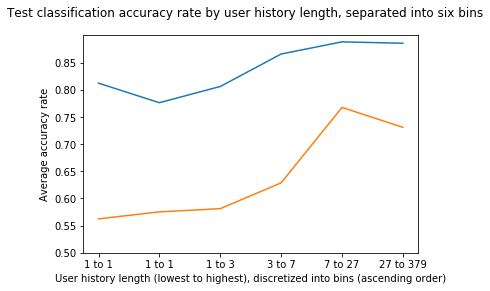

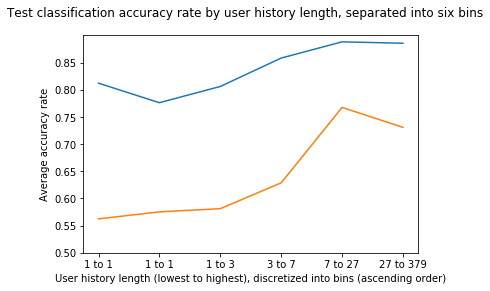

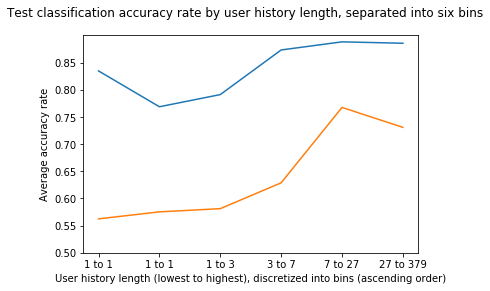

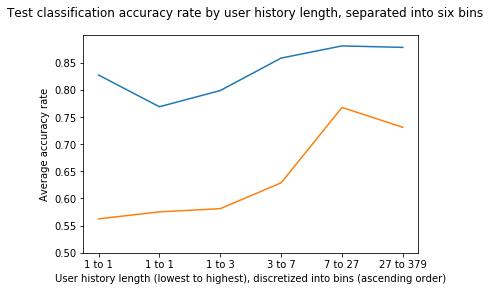

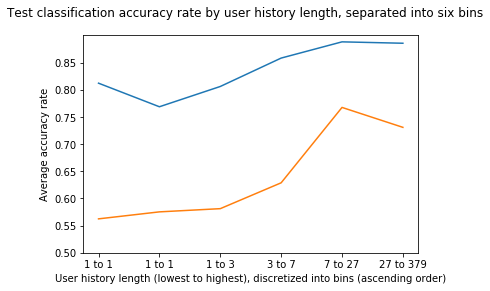

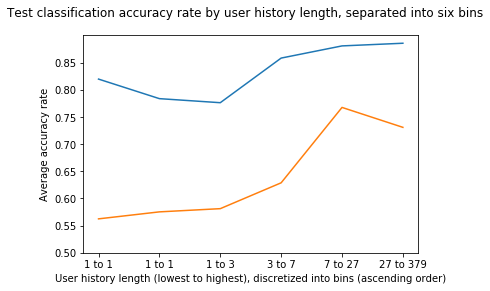

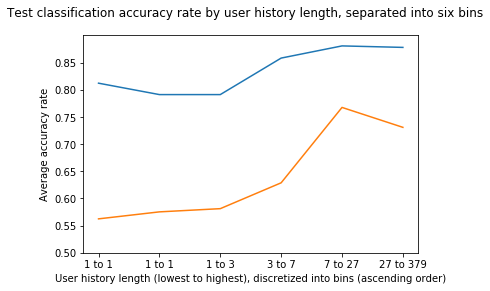

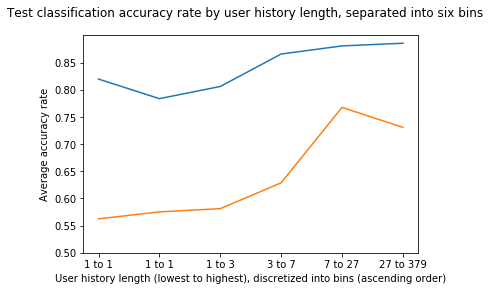

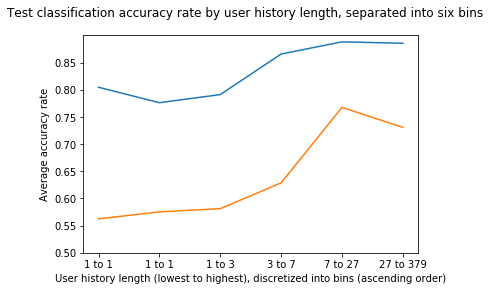

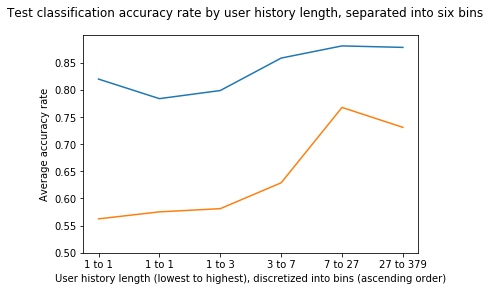

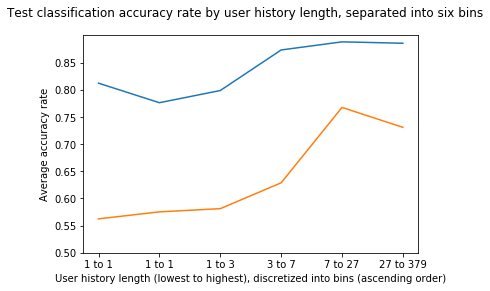

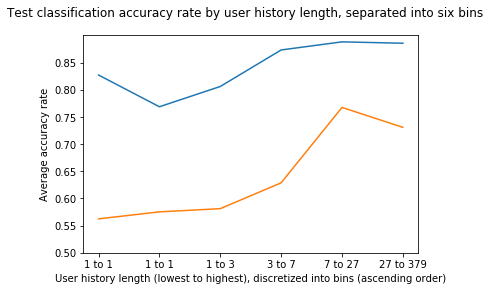

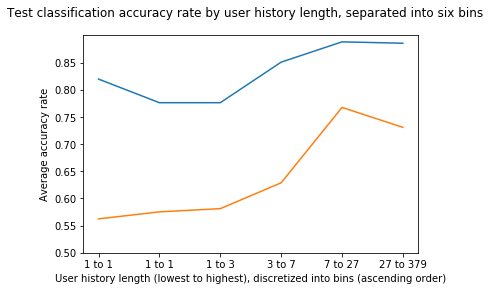

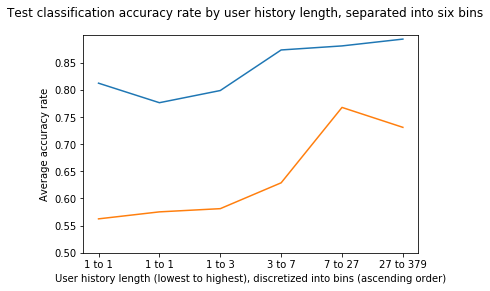

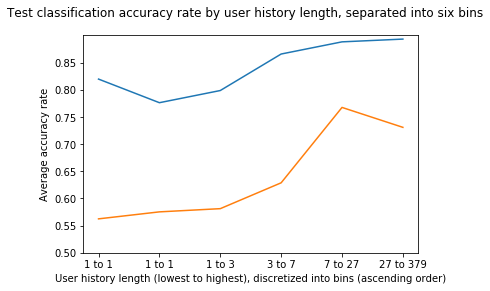

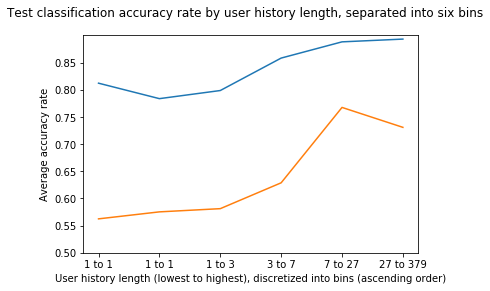

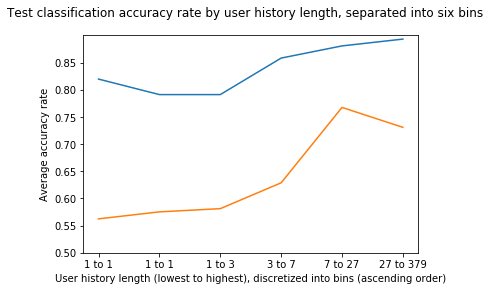

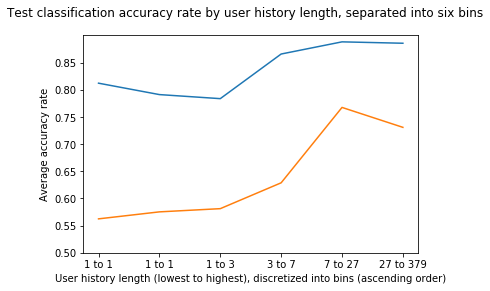

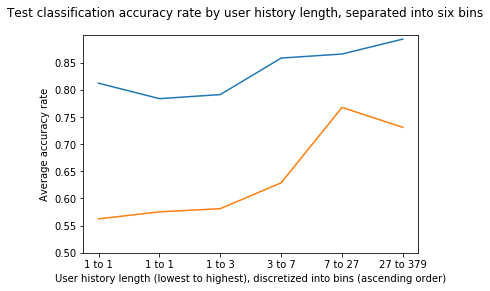

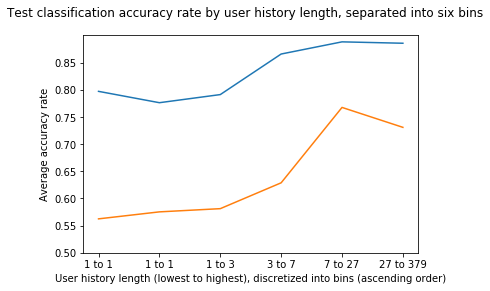

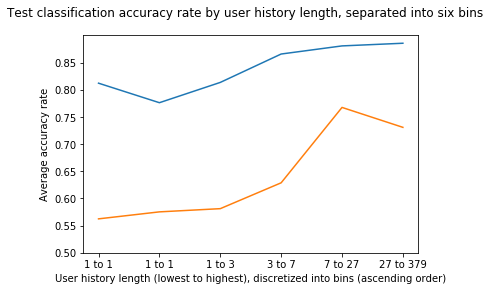

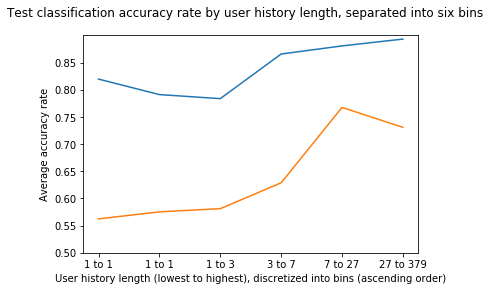

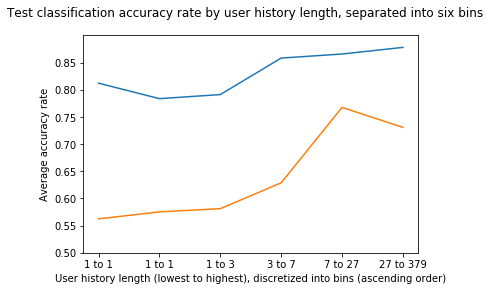

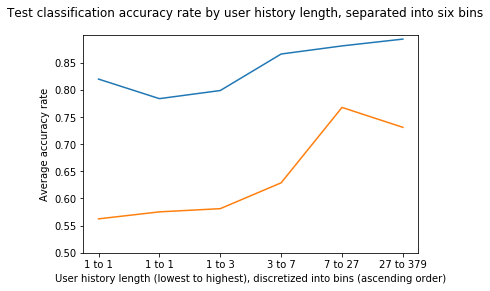

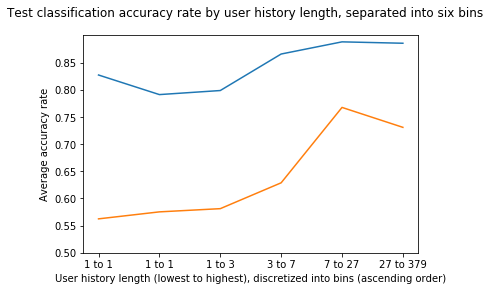

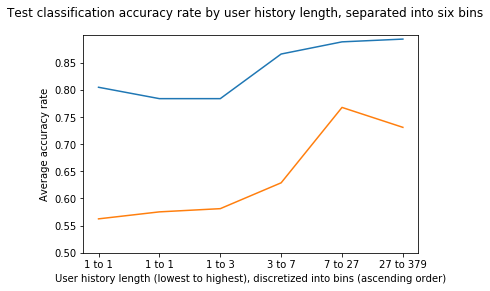

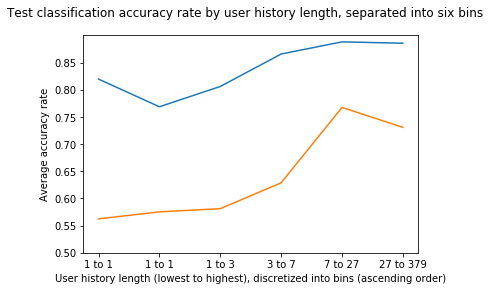

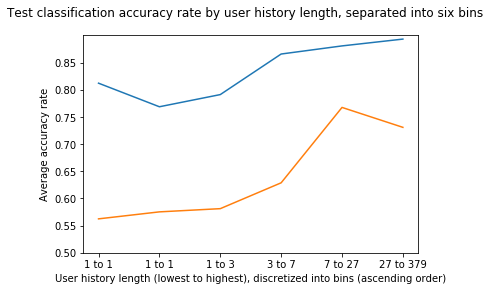

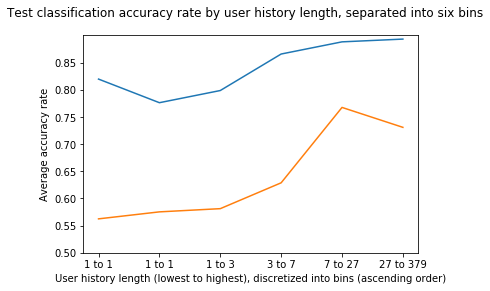

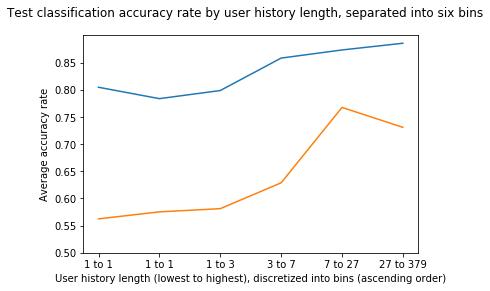

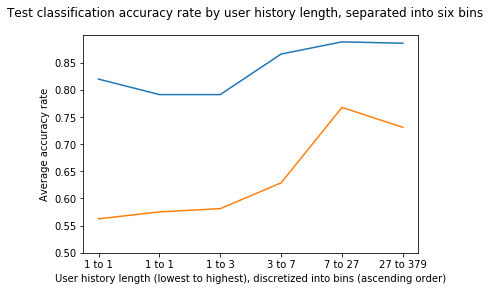

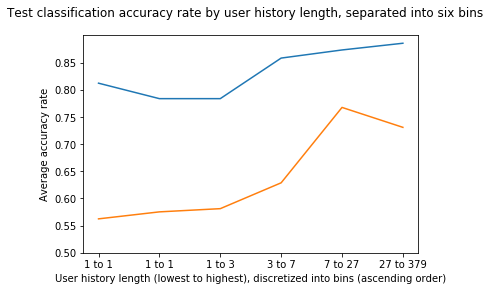

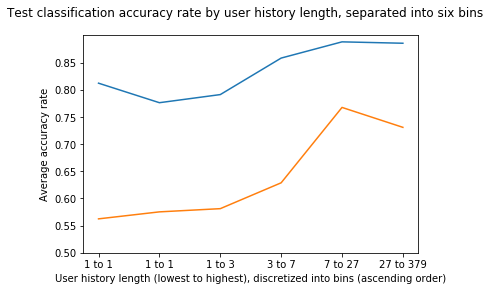

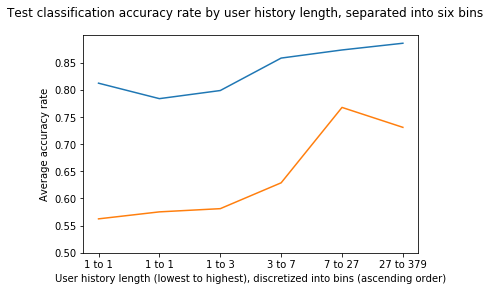

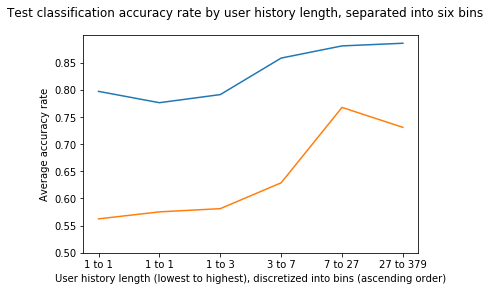

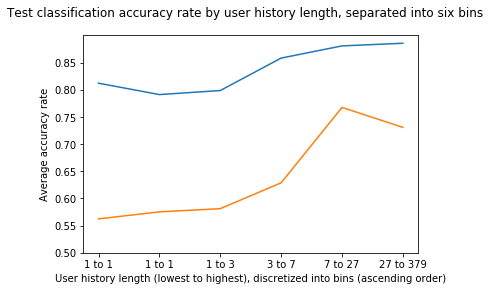

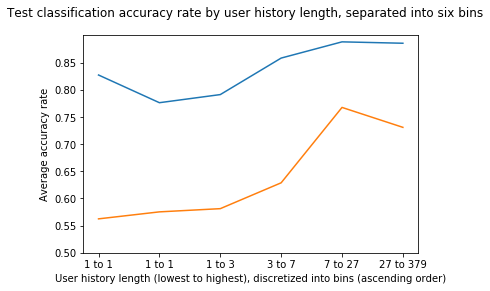

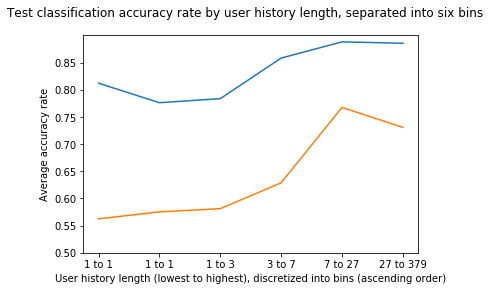

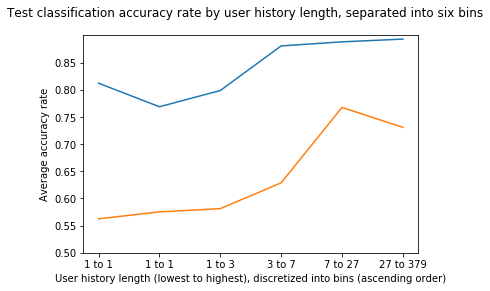

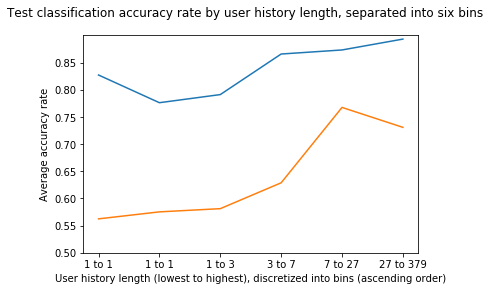

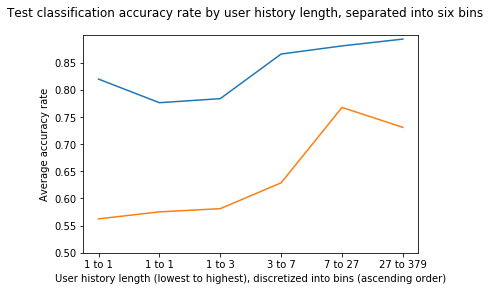

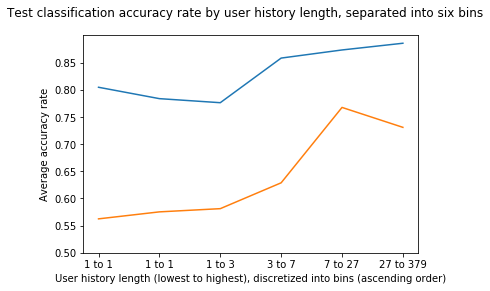

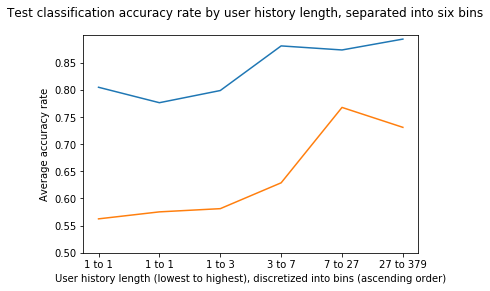

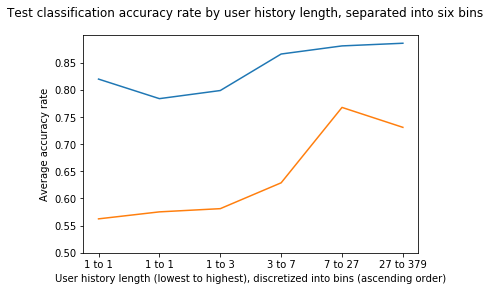

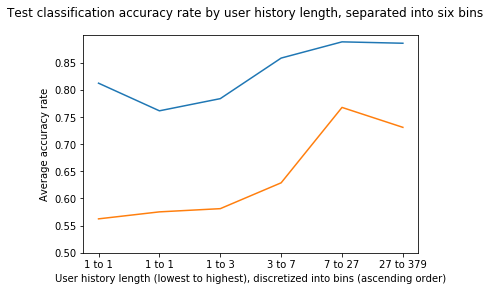

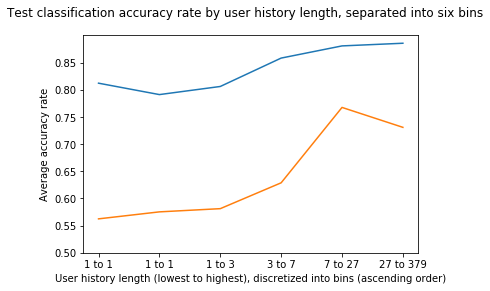

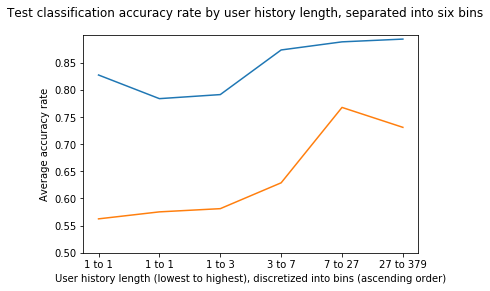

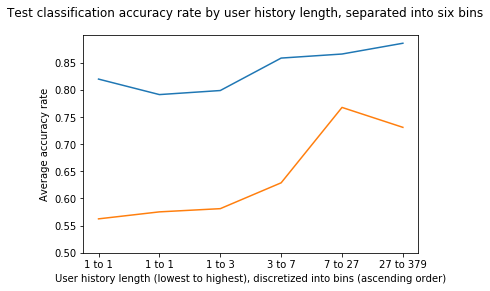

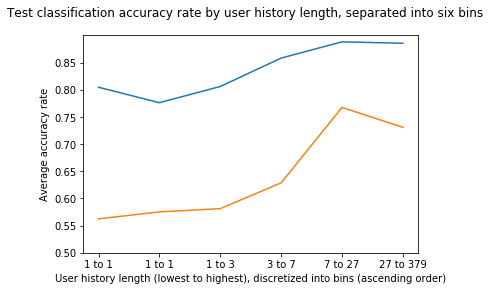

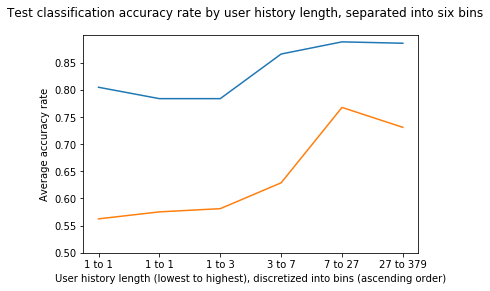

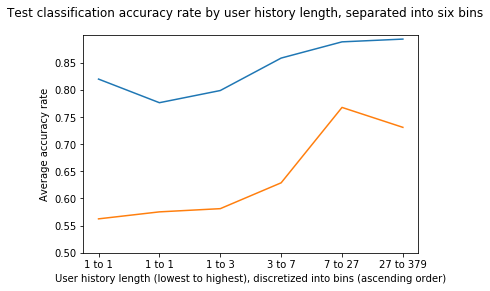

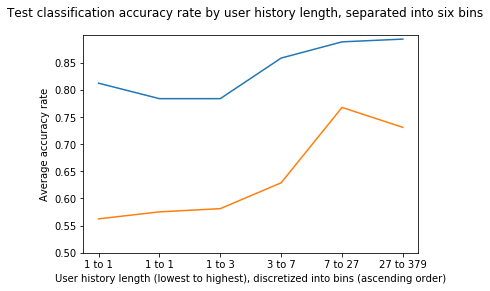

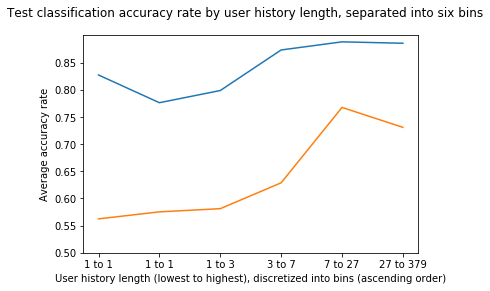

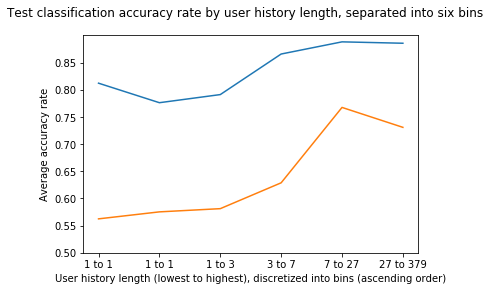

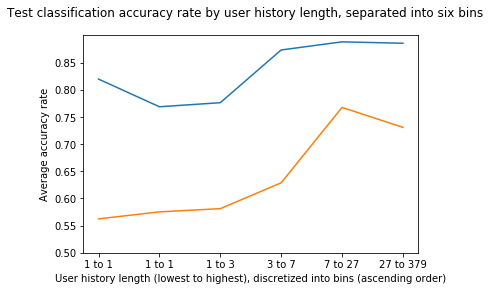

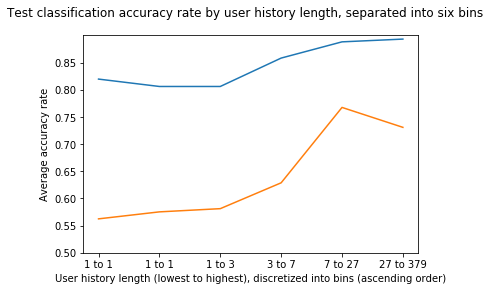

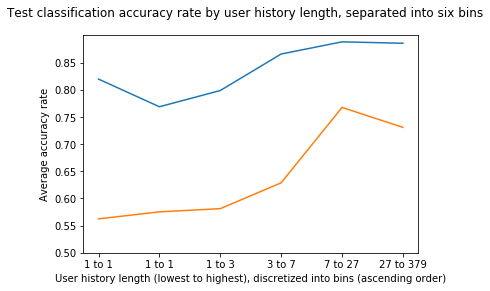

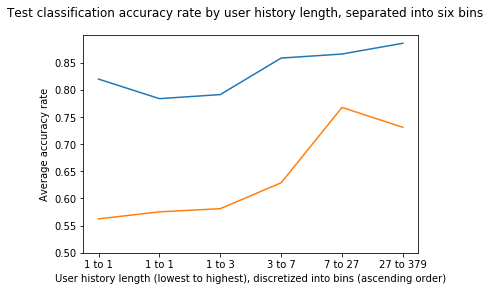

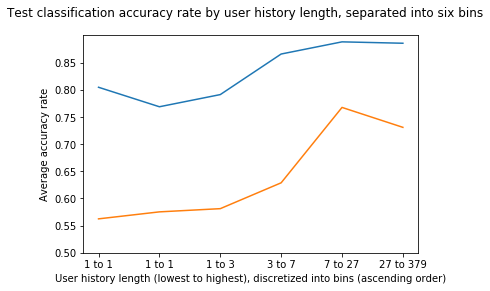

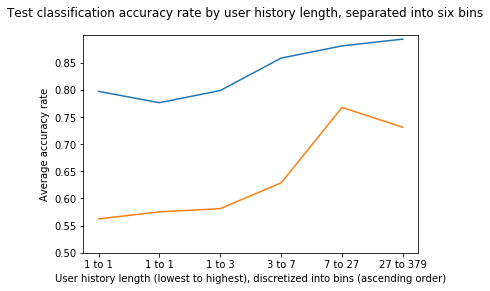

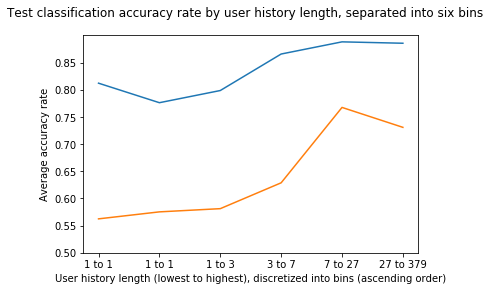

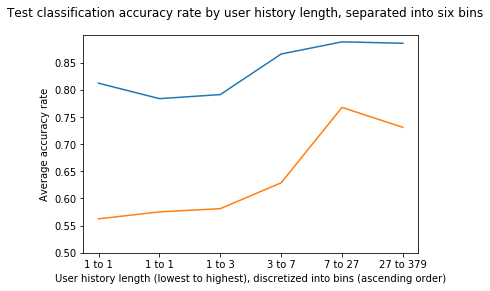

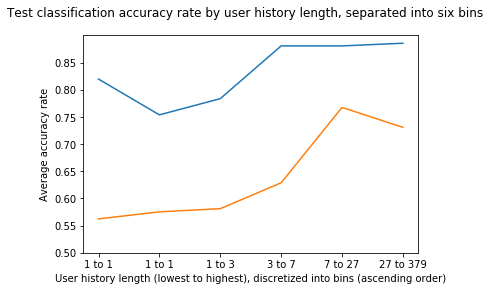

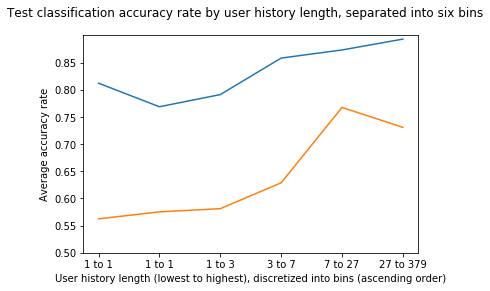

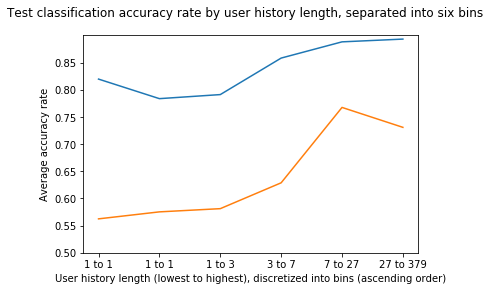

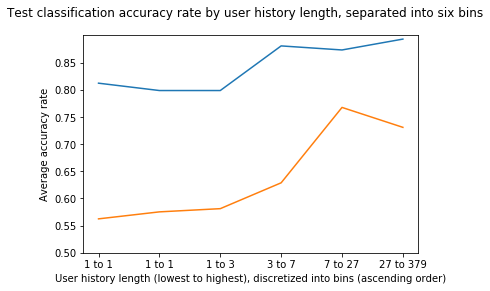

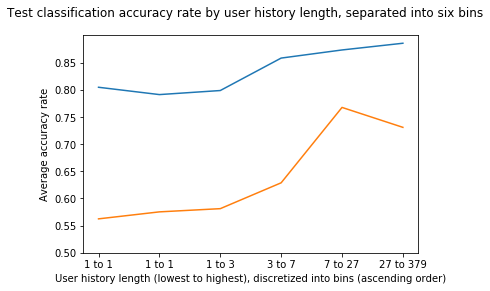

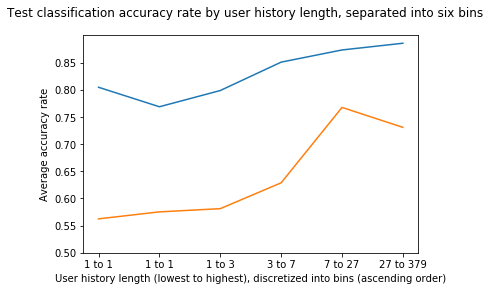

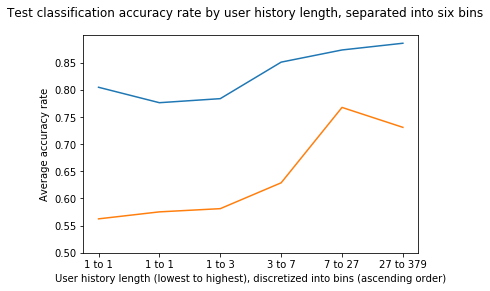

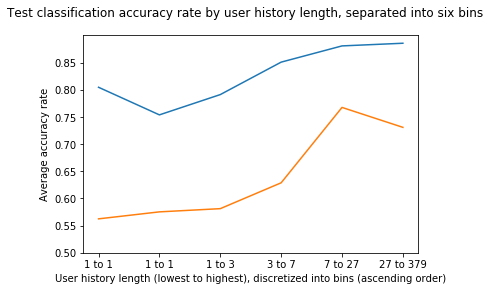

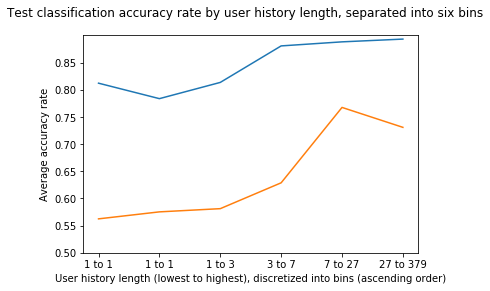

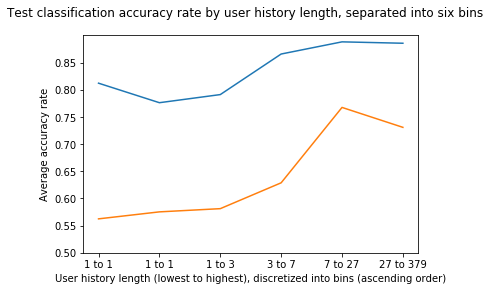

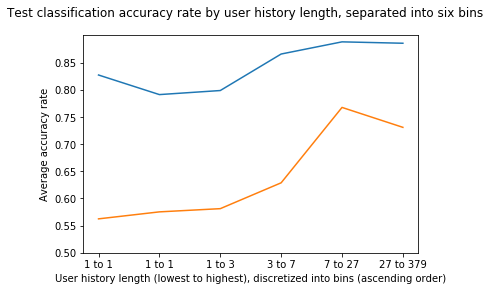

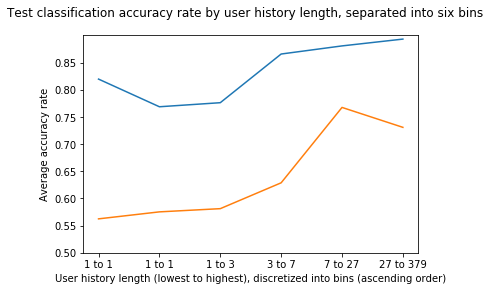

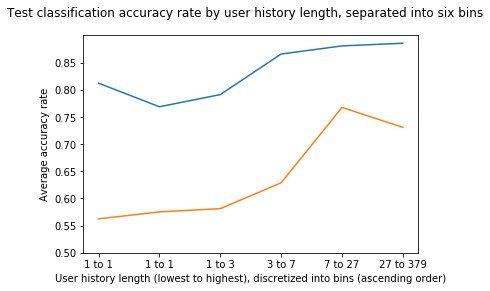

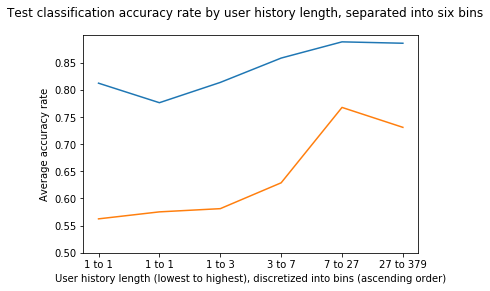

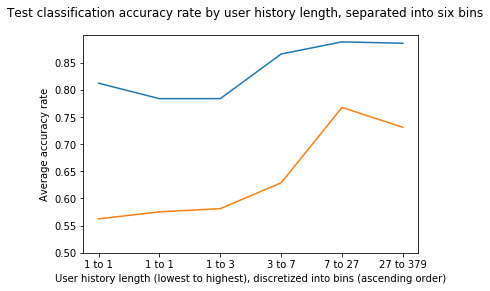

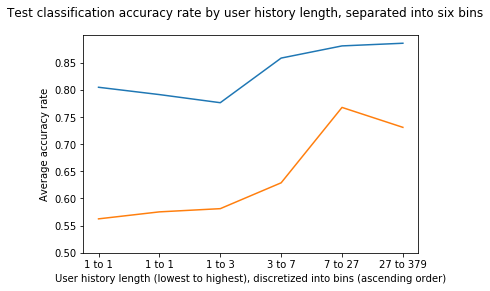

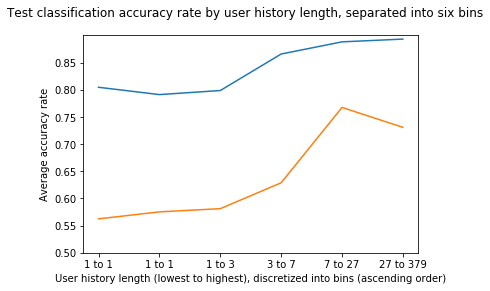

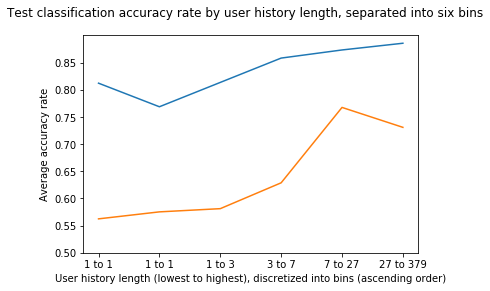

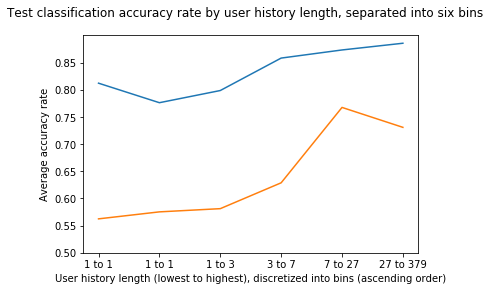

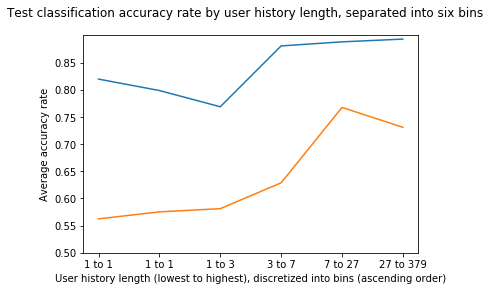

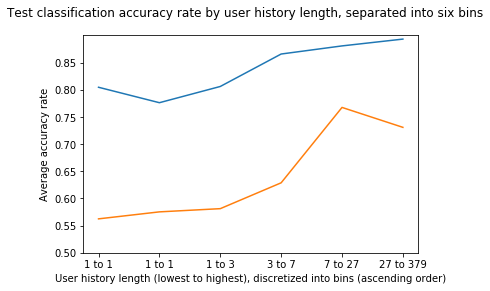

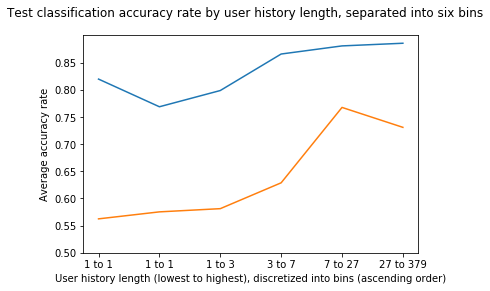

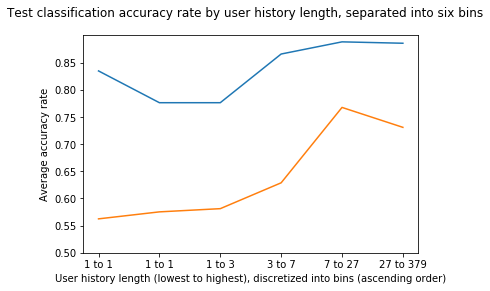

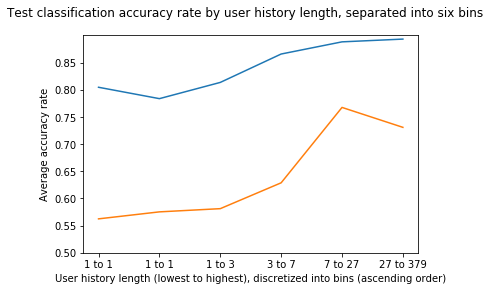

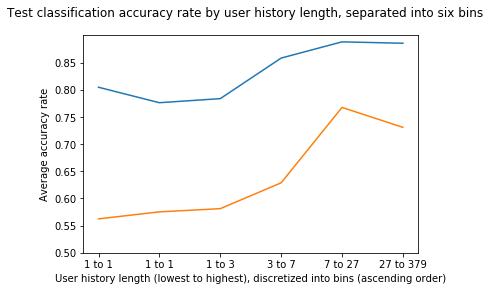

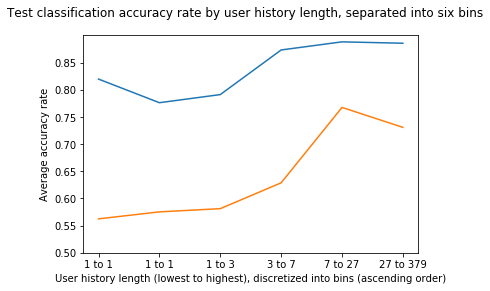

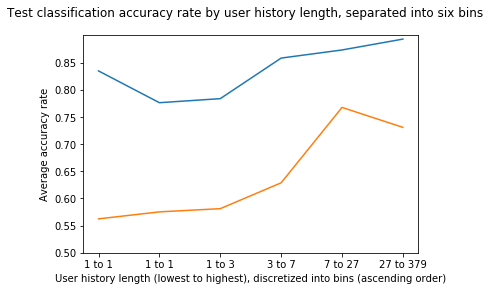

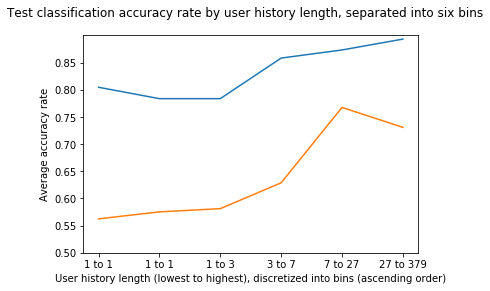

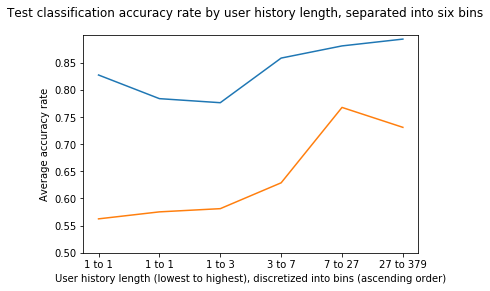

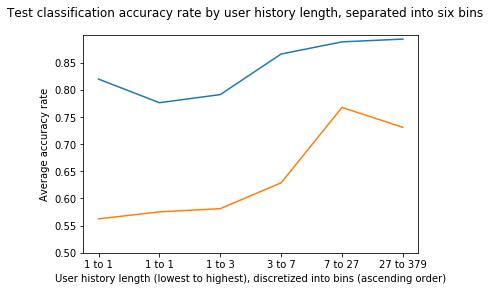

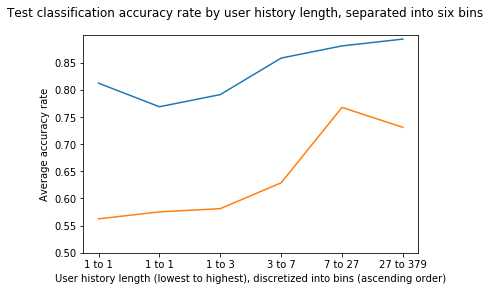

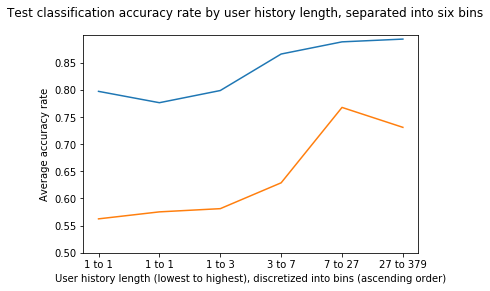

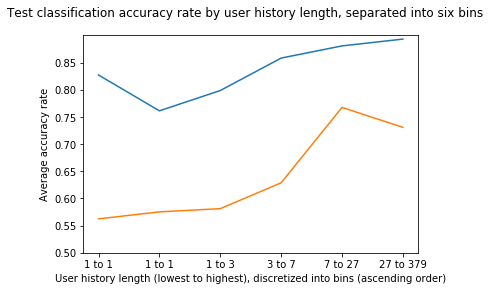

In [10]:


acc, auc, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

0.8365875000000003
0.8438815633869444


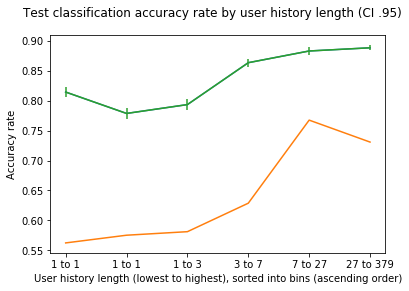

In [11]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    for i in range(NUM_TESTS):
        print('STARTING ****************************************************', i)

        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        running_acc += baseline.get_accuracy(torch.Tensor(X_test), torch.Tensor(y_test))
        running_auc += baseline.get_auc(torch.Tensor(X_test), torch.Tensor(y_test))
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test), X_hist_len_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, bin_names, graph_results, priors_list

In [13]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove

STARTING **************************************************** 0
epoch: 0 learning rate: [0.007982950726461421]
[1,   200] loss: 0.549
[1,   400] loss: 0.417
[1,   600] loss: 0.362
[1,   800] loss: 0.369
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.337
[2,   400] loss: 0.328
[2,   600] loss: 0.342
[2,   800] loss: 0.334
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.305
[3,   400] loss: 0.293
[3,   600] loss: 0.368
[3,   800] loss: 0.323
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 

[1,   200] loss: 0.542
[1,   400] loss: 0.416
[1,   600] loss: 0.374
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.343
[2,   400] loss: 0.329
[2,   600] loss: 0.335
[2,   800] loss: 0.332
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.349
[3,   400] loss: 0.313
[3,   600] loss: 0.301
[3,   800] loss: 0.327
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

[1,   200] loss: 0.537
[1,   400] loss: 0.413
[1,   600] loss: 0.388
[1,   800] loss: 0.369
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.321
[2,   400] loss: 0.361
[2,   600] loss: 0.328
[2,   800] loss: 0.327
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.316
[3,   400] loss: 0.320
[3,   600] loss: 0.329
[3,   800] loss: 0.323
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.525
[1,   400] loss: 0.414
[1,   600] loss: 0.378
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.330
[2,   400] loss: 0.326
[2,   600] loss: 0.340
[2,   800] loss: 0.332
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.287
[3,   400] loss: 0.338
[3,   600] loss: 0.310
[3,   800] loss: 0.344
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.377
[1,   600] loss: 0.415
[1,   800] loss: 0.371
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.351
[2,   400] loss: 0.336
[2,   600] loss: 0.343
[2,   800] loss: 0.310
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.317
[3,   400] loss: 0.326
[3,   600] loss: 0.332
[3,   800] loss: 0.315
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.547
[1,   400] loss: 0.416
[1,   600] loss: 0.384
[1,   800] loss: 0.340
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.352
[2,   400] loss: 0.320
[2,   600] loss: 0.332
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.298
[3,   400] loss: 0.335
[3,   600] loss: 0.309
[3,   800] loss: 0.338
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.08628376606346733
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.410
[1,   600] loss: 0.373
[1,   800] loss: 0.383
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.317
[2,   400] loss: 0.344
[2,   600] loss: 0.337
[2,   800] loss: 0.331
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.297
[3,   400] loss: 0.331
[3,   600] loss: 0.340
[3,   800] loss: 0.315
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.408
[1,   600] loss: 0.379
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.330
[2,   400] loss: 0.314
[2,   600] loss: 0.371
[2,   800] loss: 0.326
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.315
[3,   400] loss: 0.350
[3,   600] loss: 0.320
[3,   800] loss: 0.303
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.526
[1,   400] loss: 0.386
[1,   600] loss: 0.385
[1,   800] loss: 0.390
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.318
[2,   400] loss: 0.328
[2,   600] loss: 0.344
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.325
[3,   400] loss: 0.312
[3,   600] loss: 0.324
[3,   800] loss: 0.316
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *******************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.536
[1,   400] loss: 0.415
[1,   600] loss: 0.379
[1,   800] loss: 0.359
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.343
[2,   400] loss: 0.340
[2,   600] loss: 0.321
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.314
[3,   400] loss: 0.339
[3,   600] loss: 0.318
[3,   800] loss: 0.310
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.419
[1,   600] loss: 0.349
[1,   800] loss: 0.388
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.322
[2,   400] loss: 0.334
[2,   600] loss: 0.360
[2,   800] loss: 0.319
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.344
[3,   400] loss: 0.298
[3,   600] loss: 0.308
[3,   800] loss: 0.335
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.432
[1,   600] loss: 0.379
[1,   800] loss: 0.372
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.306
[2,   400] loss: 0.313
[2,   600] loss: 0.343
[2,   800] loss: 0.370
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.327
[3,   400] loss: 0.331
[3,   600] loss: 0.330
[3,   800] loss: 0.297
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.536
[1,   400] loss: 0.401
[1,   600] loss: 0.399
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.344
[2,   400] loss: 0.324
[2,   600] loss: 0.332
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.306
[3,   400] loss: 0.311
[3,   600] loss: 0.327
[3,   800] loss: 0.330
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.560
[1,   400] loss: 0.407
[1,   600] loss: 0.378
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.329
[2,   400] loss: 0.325
[2,   600] loss: 0.327
[2,   800] loss: 0.365
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.313
[3,   400] loss: 0.324
[3,   600] loss: 0.337
[3,   800] loss: 0.320
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.541
[1,   400] loss: 0.407
[1,   600] loss: 0.376
[1,   800] loss: 0.354
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.309
[2,   400] loss: 0.353
[2,   600] loss: 0.327
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.320
[3,   400] loss: 0.327
[3,   600] loss: 0.316
[3,   800] loss: 0.320
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.430
[1,   600] loss: 0.369
[1,   800] loss: 0.361
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.333
[2,   400] loss: 0.334
[2,   600] loss: 0.361
[2,   800] loss: 0.317
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.325
[3,   400] loss: 0.326
[3,   600] loss: 0.313
[3,   800] loss: 0.328
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.544
[1,   400] loss: 0.400
[1,   600] loss: 0.402
[1,   800] loss: 0.367
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.342
[2,   400] loss: 0.306
[2,   600] loss: 0.335
[2,   800] loss: 0.352
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.328
[3,   400] loss: 0.308
[3,   600] loss: 0.314
[3,   800] loss: 0.336
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.540
[1,   400] loss: 0.416
[1,   600] loss: 0.383
[1,   800] loss: 0.355
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.336
[2,   400] loss: 0.331
[2,   600] loss: 0.350
[2,   800] loss: 0.312
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.305
[3,   400] loss: 0.335
[3,   600] loss: 0.307
[3,   800] loss: 0.331
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.527
[1,   400] loss: 0.412
[1,   600] loss: 0.398
[1,   800] loss: 0.357
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.342
[2,   400] loss: 0.319
[2,   600] loss: 0.327
[2,   800] loss: 0.342
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.317
[3,   400] loss: 0.364
[3,   600] loss: 0.285
[3,   800] loss: 0.314
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.540
[1,   400] loss: 0.423
[1,   600] loss: 0.348
[1,   800] loss: 0.398
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.351
[2,   400] loss: 0.333
[2,   600] loss: 0.342
[2,   800] loss: 0.316
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.364
[3,   400] loss: 0.287
[3,   600] loss: 0.298
[3,   800] loss: 0.344
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.2515957446808511
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.558
[1,   400] loss: 0.420
[1,   600] loss: 0.365
[1,   800] loss: 0.352
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.317
[2,   400] loss: 0.336
[2,   600] loss: 0.361
[2,   800] loss: 0.321
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.324
[3,   400] loss: 0.337
[3,   600] loss: 0.314
[3,   800] loss: 0.309
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.544
[1,   400] loss: 0.423
[1,   600] loss: 0.388
[1,   800] loss: 0.354
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.320
[2,   400] loss: 0.348
[2,   600] loss: 0.288
[2,   800] loss: 0.376
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.293
[3,   400] loss: 0.332
[3,   600] loss: 0.306
[3,   800] loss: 0.352
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.12457382638342485
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.533
[1,   400] loss: 0.404
[1,   600] loss: 0.396
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.332
[2,   400] loss: 0.316
[2,   600] loss: 0.322
[2,   800] loss: 0.351
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.307
[3,   400] loss: 0.317
[3,   600] loss: 0.326
[3,   800] loss: 0.321
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.4371437143714372
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.543
[1,   400] loss: 0.422
[1,   600] loss: 0.385
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.335
[2,   400] loss: 0.350
[2,   600] loss: 0.329
[2,   800] loss: 0.324
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.344
[3,   400] loss: 0.317
[3,   600] loss: 0.320
[3,   800] loss: 0.308
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.535
[1,   400] loss: 0.388
[1,   600] loss: 0.402
[1,   800] loss: 0.377
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.318
[2,   400] loss: 0.338
[2,   600] loss: 0.345
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.316
[3,   400] loss: 0.320
[3,   600] loss: 0.320
[3,   800] loss: 0.319
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.559
[1,   400] loss: 0.429
[1,   600] loss: 0.388
[1,   800] loss: 0.348
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.312
[2,   400] loss: 0.355
[2,   600] loss: 0.359
[2,   800] loss: 0.310
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.313
[3,   400] loss: 0.327
[3,   600] loss: 0.306
[3,   800] loss: 0.340
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.533
[1,   400] loss: 0.425
[1,   600] loss: 0.367
[1,   800] loss: 0.381
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.334
[2,   400] loss: 0.335
[2,   600] loss: 0.347
[2,   800] loss: 0.318
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.316
[3,   400] loss: 0.304
[3,   600] loss: 0.340
[3,   800] loss: 0.325
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.534
[1,   400] loss: 0.400
[1,   600] loss: 0.363
[1,   800] loss: 0.411
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.323
[2,   400] loss: 0.337
[2,   600] loss: 0.347
[2,   800] loss: 0.325
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.330
[3,   400] loss: 0.327
[3,   600] loss: 0.332
[3,   800] loss: 0.292
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.543
[1,   400] loss: 0.399
[1,   600] loss: 0.371
[1,   800] loss: 0.385
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.321
[2,   400] loss: 0.334
[2,   600] loss: 0.369
[2,   800] loss: 0.302
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.332
[3,   400] loss: 0.314
[3,   600] loss: 0.336
[3,   800] loss: 0.293
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.407
[1,   600] loss: 0.369
[1,   800] loss: 0.354
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.326
[2,   400] loss: 0.341
[2,   600] loss: 0.321
[2,   800] loss: 0.343
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.324
[3,   400] loss: 0.313
[3,   600] loss: 0.327
[3,   800] loss: 0.318
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.434
[1,   600] loss: 0.363
[1,   800] loss: 0.377
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.329
[2,   400] loss: 0.324
[2,   600] loss: 0.352
[2,   800] loss: 0.335
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.325
[3,   400] loss: 0.315
[3,   600] loss: 0.285
[3,   800] loss: 0.367
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.529
[1,   400] loss: 0.396
[1,   600] loss: 0.371
[1,   800] loss: 0.390
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.355
[2,   400] loss: 0.317
[2,   600] loss: 0.332
[2,   800] loss: 0.327
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.299
[3,   400] loss: 0.317
[3,   600] loss: 0.342
[3,   800] loss: 0.323
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.534
[1,   400] loss: 0.421
[1,   600] loss: 0.383
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.312
[2,   400] loss: 0.347
[2,   600] loss: 0.352
[2,   800] loss: 0.321
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.308
[3,   400] loss: 0.326
[3,   600] loss: 0.322
[3,   800] loss: 0.327
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.407
[1,   600] loss: 0.359
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.338
[2,   400] loss: 0.343
[2,   600] loss: 0.345
[2,   800] loss: 0.305
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.303
[3,   400] loss: 0.334
[3,   600] loss: 0.313
[3,   800] loss: 0.334
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.523
[1,   400] loss: 0.418
[1,   600] loss: 0.384
[1,   800] loss: 0.372
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.346
[2,   400] loss: 0.337
[2,   600] loss: 0.322
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.304
[3,   400] loss: 0.334
[3,   600] loss: 0.327
[3,   800] loss: 0.320
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.396939693969397
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.542
[1,   400] loss: 0.417
[1,   600] loss: 0.402
[1,   800] loss: 0.379
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.347
[2,   400] loss: 0.350
[2,   600] loss: 0.328
[2,   800] loss: 0.321
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.297
[3,   400] loss: 0.341
[3,   600] loss: 0.320
[3,   800] loss: 0.337
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.563
[1,   400] loss: 0.418
[1,   600] loss: 0.355
[1,   800] loss: 0.377
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.323
[2,   400] loss: 0.323
[2,   600] loss: 0.350
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.332
[3,   400] loss: 0.306
[3,   600] loss: 0.315
[3,   800] loss: 0.331
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.565
[1,   400] loss: 0.383
[1,   600] loss: 0.372
[1,   800] loss: 0.376
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.328
[2,   400] loss: 0.309
[2,   600] loss: 0.352
[2,   800] loss: 0.339
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.309
[3,   400] loss: 0.327
[3,   600] loss: 0.317
[3,   800] loss: 0.328
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2872340425531915
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.417
[1,   600] loss: 0.385
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.323
[2,   400] loss: 0.330
[2,   600] loss: 0.347
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.337
[3,   400] loss: 0.302
[3,   600] loss: 0.319
[3,   800] loss: 0.322
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.1565696302124313
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.400
[1,   600] loss: 0.384
[1,   800] loss: 0.387
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.346
[2,   400] loss: 0.323
[2,   600] loss: 0.341
[2,   800] loss: 0.322
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.324
[3,   400] loss: 0.316
[3,   600] loss: 0.316
[3,   800] loss: 0.324
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.428
[1,   600] loss: 0.375
[1,   800] loss: 0.362
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.323
[2,   400] loss: 0.330
[2,   600] loss: 0.342
[2,   800] loss: 0.337
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.303
[3,   400] loss: 0.326
[3,   600] loss: 0.319
[3,   800] loss: 0.335
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.522
[1,   400] loss: 0.409
[1,   600] loss: 0.372
[1,   800] loss: 0.389
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.338
[2,   400] loss: 0.331
[2,   600] loss: 0.343
[2,   800] loss: 0.319
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.329
[3,   400] loss: 0.300
[3,   600] loss: 0.345
[3,   800] loss: 0.309
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.542
[1,   400] loss: 0.428
[1,   600] loss: 0.374
[1,   800] loss: 0.356
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.309
[2,   400] loss: 0.348
[2,   600] loss: 0.318
[2,   800] loss: 0.356
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.342
[3,   400] loss: 0.304
[3,   600] loss: 0.328
[3,   800] loss: 0.305
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.513
[1,   400] loss: 0.389
[1,   600] loss: 0.406
[1,   800] loss: 0.392
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.328
[2,   400] loss: 0.360
[2,   600] loss: 0.319
[2,   800] loss: 0.321
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.323
[3,   400] loss: 0.310
[3,   600] loss: 0.316
[3,   800] loss: 0.330
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.396939693969397
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.426
[1,   600] loss: 0.378
[1,   800] loss: 0.359
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.336
[2,   400] loss: 0.331
[2,   600] loss: 0.332
[2,   800] loss: 0.337
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.342
[3,   400] loss: 0.341
[3,   600] loss: 0.288
[3,   800] loss: 0.318
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.423
[1,   600] loss: 0.374
[1,   800] loss: 0.363
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.332
[2,   400] loss: 0.349
[2,   600] loss: 0.316
[2,   800] loss: 0.326
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.315
[3,   400] loss: 0.336
[3,   600] loss: 0.305
[3,   800] loss: 0.319
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.08628376606346733
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.536
[1,   400] loss: 0.401
[1,   600] loss: 0.386
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.324
[2,   400] loss: 0.328
[2,   600] loss: 0.353
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.309
[3,   400] loss: 0.324
[3,   600] loss: 0.331
[3,   800] loss: 0.318
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.1597167584579069
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.416
[1,   600] loss: 0.337
[1,   800] loss: 0.388
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.316
[2,   400] loss: 0.333
[2,   600] loss: 0.336
[2,   800] loss: 0.350
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.326
[3,   400] loss: 0.327
[3,   600] loss: 0.322
[3,   800] loss: 0.310
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.394
[1,   600] loss: 0.384
[1,   800] loss: 0.388
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.348
[2,   400] loss: 0.338
[2,   600] loss: 0.343
[2,   800] loss: 0.297
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.326
[3,   400] loss: 0.345
[3,   600] loss: 0.303
[3,   800] loss: 0.304
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.530
[1,   400] loss: 0.412
[1,   600] loss: 0.396
[1,   800] loss: 0.358
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.327
[2,   400] loss: 0.321
[2,   600] loss: 0.332
[2,   800] loss: 0.339
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.301
[3,   400] loss: 0.318
[3,   600] loss: 0.332
[3,   800] loss: 0.319
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.396939693969397
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.538
[1,   400] loss: 0.415
[1,   600] loss: 0.395
[1,   800] loss: 0.365
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.328
[2,   400] loss: 0.348
[2,   600] loss: 0.346
[2,   800] loss: 0.306
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.333
[3,   400] loss: 0.329
[3,   600] loss: 0.317
[3,   800] loss: 0.299
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.544
[1,   400] loss: 0.428
[1,   600] loss: 0.397
[1,   800] loss: 0.358
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.375
[2,   400] loss: 0.326
[2,   600] loss: 0.309
[2,   800] loss: 0.332
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.328
[3,   400] loss: 0.296
[3,   600] loss: 0.324
[3,   800] loss: 0.341
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.532
[1,   400] loss: 0.407
[1,   600] loss: 0.397
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.325
[2,   400] loss: 0.332
[2,   600] loss: 0.337
[2,   800] loss: 0.339
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.330
[3,   400] loss: 0.318
[3,   600] loss: 0.307
[3,   800] loss: 0.331
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.545
[1,   400] loss: 0.408
[1,   600] loss: 0.379
[1,   800] loss: 0.359
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.330
[2,   400] loss: 0.323
[2,   600] loss: 0.367
[2,   800] loss: 0.298
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.336
[3,   400] loss: 0.317
[3,   600] loss: 0.307
[3,   800] loss: 0.309
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.416
[1,   600] loss: 0.365
[1,   800] loss: 0.382
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.316
[2,   400] loss: 0.341
[2,   600] loss: 0.361
[2,   800] loss: 0.310
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.304
[3,   400] loss: 0.328
[3,   600] loss: 0.323
[3,   800] loss: 0.328
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.554
[1,   400] loss: 0.397
[1,   600] loss: 0.389
[1,   800] loss: 0.379
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.345
[2,   400] loss: 0.340
[2,   600] loss: 0.340
[2,   800] loss: 0.315
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.301
[3,   400] loss: 0.328
[3,   600] loss: 0.333
[3,   800] loss: 0.331
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.542
[1,   400] loss: 0.412
[1,   600] loss: 0.368
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.331
[2,   400] loss: 0.345
[2,   600] loss: 0.308
[2,   800] loss: 0.342
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.332
[3,   400] loss: 0.294
[3,   600] loss: 0.338
[3,   800] loss: 0.313
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.1803191489361703
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.556
[1,   400] loss: 0.417
[1,   600] loss: 0.366
[1,   800] loss: 0.376
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.333
[2,   400] loss: 0.332
[2,   600] loss: 0.345
[2,   800] loss: 0.333
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.303
[3,   400] loss: 0.318
[3,   600] loss: 0.323
[3,   800] loss: 0.345
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.396939693969397
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.531
[1,   400] loss: 0.377
[1,   600] loss: 0.420
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.333
[2,   400] loss: 0.334
[2,   600] loss: 0.313
[2,   800] loss: 0.351
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.331
[3,   400] loss: 0.324
[3,   600] loss: 0.321
[3,   800] loss: 0.306
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = 0.08628376606346733
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.442
[1,   600] loss: 0.372
[1,   800] loss: 0.346
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.346
[2,   400] loss: 0.347
[2,   600] loss: 0.347
[2,   800] loss: 0.301
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.327
[3,   400] loss: 0.302
[3,   600] loss: 0.363
[3,   800] loss: 0.302
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.535
[1,   400] loss: 0.401
[1,   600] loss: 0.379
[1,   800] loss: 0.392
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.349
[2,   400] loss: 0.317
[2,   600] loss: 0.331
[2,   800] loss: 0.336
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.321
[3,   400] loss: 0.332
[3,   600] loss: 0.311
[3,   800] loss: 0.318
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.0894308943089428
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.539
[1,   400] loss: 0.432
[1,   600] loss: 0.368
[1,   800] loss: 0.372
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.345
[2,   400] loss: 0.328
[2,   600] loss: 0.351
[2,   800] loss: 0.304
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.336
[3,   400] loss: 0.311
[3,   600] loss: 0.335
[3,   800] loss: 0.300
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.568
[1,   400] loss: 0.408
[1,   600] loss: 0.364
[1,   800] loss: 0.360
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.335
[2,   400] loss: 0.329
[2,   600] loss: 0.333
[2,   800] loss: 0.338
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.318
[3,   400] loss: 0.293
[3,   600] loss: 0.337
[3,   800] loss: 0.335
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.561
[1,   400] loss: 0.425
[1,   600] loss: 0.350
[1,   800] loss: 0.377
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.312
[2,   400] loss: 0.318
[2,   600] loss: 0.345
[2,   800] loss: 0.354
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.320
[3,   400] loss: 0.298
[3,   600] loss: 0.325
[3,   800] loss: 0.336
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.419
[1,   600] loss: 0.361
[1,   800] loss: 0.361
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.336
[2,   400] loss: 0.349
[2,   600] loss: 0.322
[2,   800] loss: 0.320
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.300
[3,   400] loss: 0.314
[3,   600] loss: 0.337
[3,   800] loss: 0.322
R2 score for bin 0 = 0.1408268733850131
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.0021276595744681437
R2 score for bin 3 = 0.19591959195919606
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.556
[1,   400] loss: 0.411
[1,   600] loss: 0.357
[1,   800] loss: 0.350
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.332
[2,   400] loss: 0.340
[2,   600] loss: 0.332
[2,   800] loss: 0.326
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.347
[3,   400] loss: 0.309
[3,   600] loss: 0.318
[3,   800] loss: 0.306
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.555
[1,   400] loss: 0.417
[1,   600] loss: 0.381
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.308
[2,   400] loss: 0.351
[2,   600] loss: 0.321
[2,   800] loss: 0.359
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.342
[3,   400] loss: 0.328
[3,   600] loss: 0.304
[3,   800] loss: 0.316
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.529
[1,   400] loss: 0.403
[1,   600] loss: 0.382
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.327
[2,   400] loss: 0.339
[2,   600] loss: 0.327
[2,   800] loss: 0.335
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.314
[3,   400] loss: 0.294
[3,   600] loss: 0.326
[3,   800] loss: 0.342
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.396
[1,   600] loss: 0.378
[1,   800] loss: 0.378
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.340
[2,   400] loss: 0.320
[2,   600] loss: 0.321
[2,   800] loss: 0.350
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.329
[3,   400] loss: 0.298
[3,   600] loss: 0.334
[3,   800] loss: 0.320
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.544
[1,   400] loss: 0.413
[1,   600] loss: 0.410
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.352
[2,   400] loss: 0.348
[2,   600] loss: 0.310
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.318
[3,   400] loss: 0.311
[3,   600] loss: 0.304
[3,   800] loss: 0.351
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.05114083398898528
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.026819923371647736
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.531
[1,   400] loss: 0.397
[1,   600] loss: 0.412
[1,   800] loss: 0.374
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.322
[2,   400] loss: 0.307
[2,   600] loss: 0.348
[2,   800] loss: 0.353
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.310
[3,   400] loss: 0.293
[3,   600] loss: 0.338
[3,   800] loss: 0.341
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.08628376606346733
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.553
[1,   400] loss: 0.405
[1,   600] loss: 0.374
[1,   800] loss: 0.380
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.307
[2,   400] loss: 0.313
[2,   600] loss: 0.336
[2,   800] loss: 0.372
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.334
[3,   400] loss: 0.307
[3,   600] loss: 0.310
[3,   800] loss: 0.331
R2 score for bin 0 = -0.06537467700258381
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.15571557155715587
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.558
[1,   400] loss: 0.407
[1,   600] loss: 0.390
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.331
[2,   400] loss: 0.317
[2,   600] loss: 0.371
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.316
[3,   400] loss: 0.299
[3,   600] loss: 0.334
[3,   800] loss: 0.338
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.03776595744680855
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.387
[1,   600] loss: 0.378
[1,   800] loss: 0.394
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.373
[2,   400] loss: 0.322
[2,   600] loss: 0.326
[2,   800] loss: 0.311
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.322
[3,   400] loss: 0.312
[3,   600] loss: 0.336
[3,   800] loss: 0.312
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3567356735673568
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.546
[1,   400] loss: 0.398
[1,   600] loss: 0.400
[1,   800] loss: 0.377
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.351
[2,   400] loss: 0.344
[2,   600] loss: 0.308
[2,   800] loss: 0.343
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.340
[3,   400] loss: 0.326
[3,   600] loss: 0.326
[3,   800] loss: 0.302
R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.23612361236123625
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING **********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.542
[1,   400] loss: 0.425
[1,   600] loss: 0.379
[1,   800] loss: 0.365
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.328
[2,   400] loss: 0.323
[2,   600] loss: 0.354
[2,   800] loss: 0.335
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.301
[3,   400] loss: 0.331
[3,   600] loss: 0.314
[3,   800] loss: 0.346
R2 score for bin 0 = 0.17519379844961258
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.540
[1,   400] loss: 0.393
[1,   600] loss: 0.403
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.317
[2,   400] loss: 0.347
[2,   600] loss: 0.336
[2,   800] loss: 0.327
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.319
[3,   400] loss: 0.327
[3,   600] loss: 0.296
[3,   800] loss: 0.336
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.547
[1,   400] loss: 0.393
[1,   600] loss: 0.414
[1,   800] loss: 0.348
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.347
[2,   400] loss: 0.315
[2,   600] loss: 0.324
[2,   800] loss: 0.335
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.334
[3,   400] loss: 0.305
[3,   600] loss: 0.322
[3,   800] loss: 0.314
R2 score for bin 0 = 0.003359173126615156
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.20606060606060594
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.550
[1,   400] loss: 0.415
[1,   600] loss: 0.377
[1,   800] loss: 0.361
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.347
[2,   400] loss: 0.315
[2,   600] loss: 0.310
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.287
[3,   400] loss: 0.341
[3,   600] loss: 0.319
[3,   800] loss: 0.333
R2 score for bin 0 = -0.03100775193798433
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.07340425531914896
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.09264069264069252
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING *********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.551
[1,   400] loss: 0.421
[1,   600] loss: 0.367
[1,   800] loss: 0.347
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.333
[2,   400] loss: 0.331
[2,   600] loss: 0.316
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.308
[3,   400] loss: 0.333
[3,   600] loss: 0.306
[3,   800] loss: 0.334
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.2159574468085107
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ************************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.537
[1,   400] loss: 0.426
[1,   600] loss: 0.362
[1,   800] loss: 0.360
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.329
[2,   400] loss: 0.335
[2,   600] loss: 0.337
[2,   800] loss: 0.317
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.316
[3,   400] loss: 0.315
[3,   600] loss: 0.308
[3,   800] loss: 0.329
R2 score for bin 0 = 0.03772609819121464
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.09099616858237569
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496
STARTING ***********************

../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


[1,   200] loss: 0.530
[1,   400] loss: 0.406
[1,   600] loss: 0.363
[1,   800] loss: 0.398
epoch: 1 learning rate: [0.0017671439676948267]
[2,   200] loss: 0.330
[2,   400] loss: 0.323
[2,   600] loss: 0.338
[2,   800] loss: 0.341
epoch: 2 learning rate: [0.00039118339941757955]
[3,   200] loss: 0.312
[3,   400] loss: 0.311
[3,   600] loss: 0.334
[3,   800] loss: 0.330
R2 score for bin 0 = 0.07209302325581413
R2 score for bin 1 = -0.019145030159978704
R2 score for bin 2 = 0.14468085106382977
R2 score for bin 3 = 0.27632763276327643
R2 score for bin 4 = -0.15517241379310365
R2 score for bin 5 = 0.14935064935064923
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


../models/baseline_mlp.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()  # initiate accuracy plot


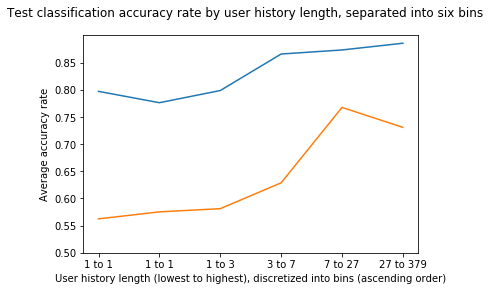

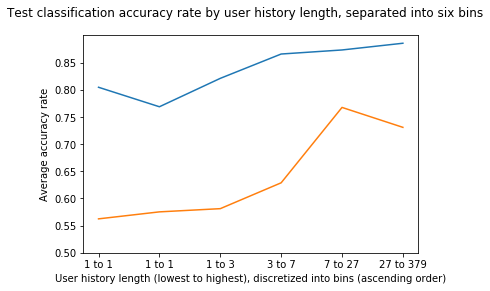

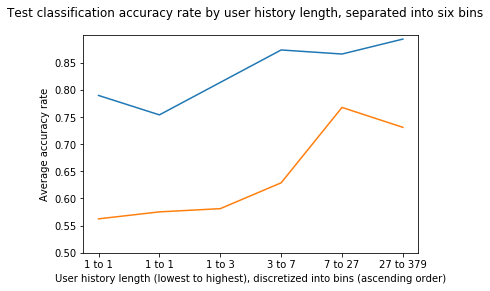

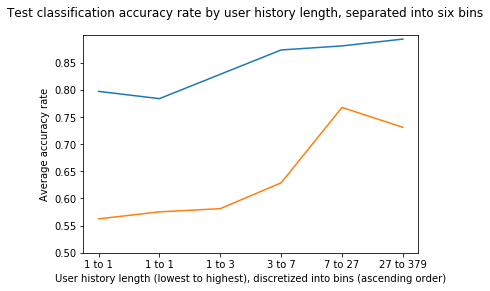

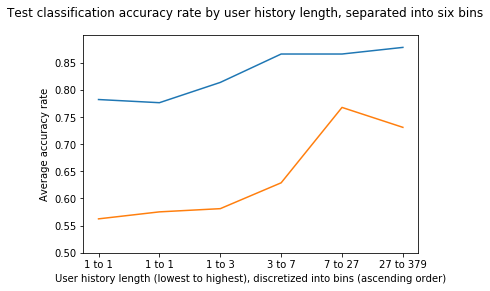

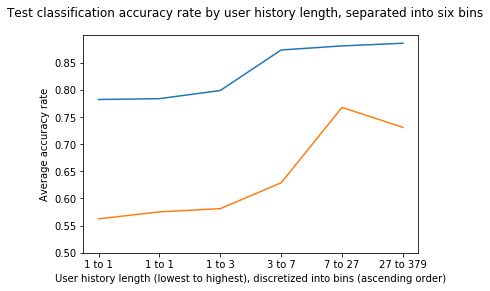

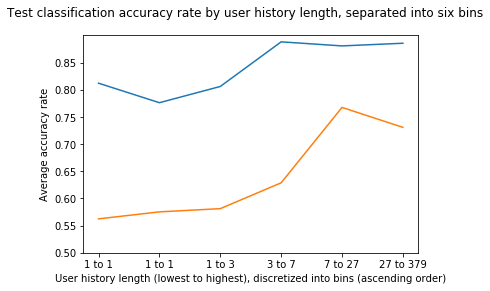

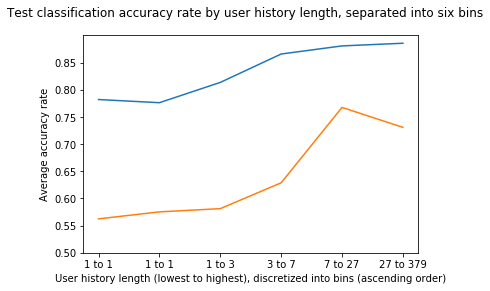

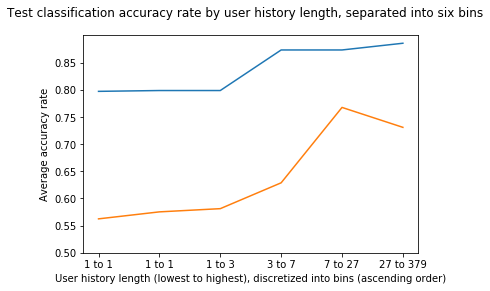

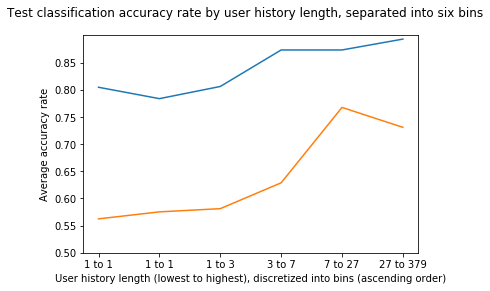

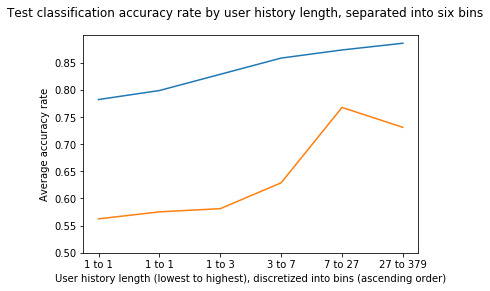

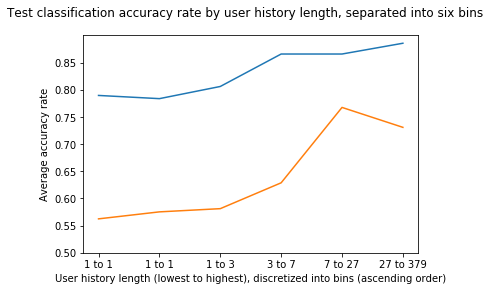

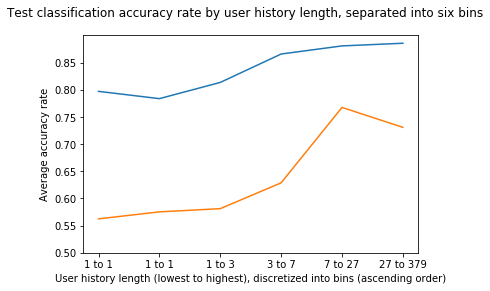

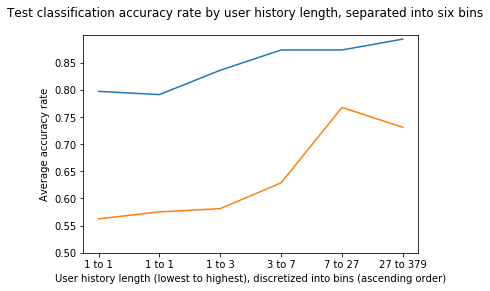

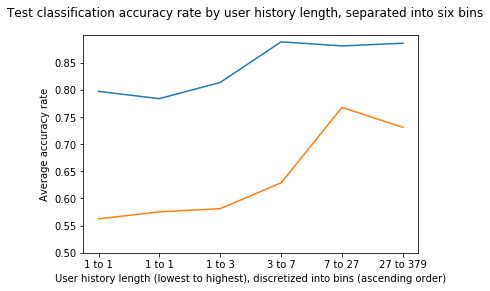

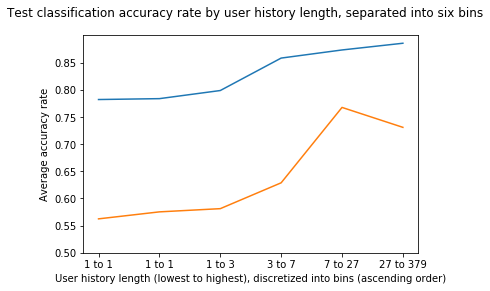

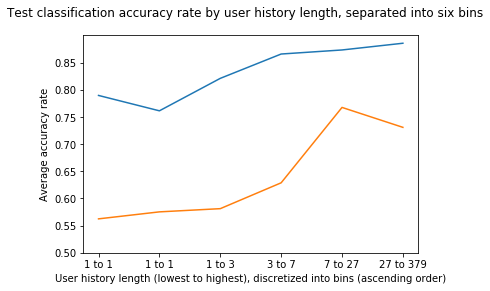

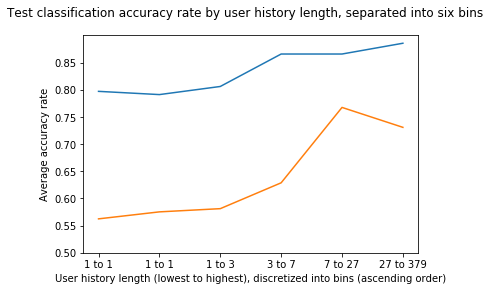

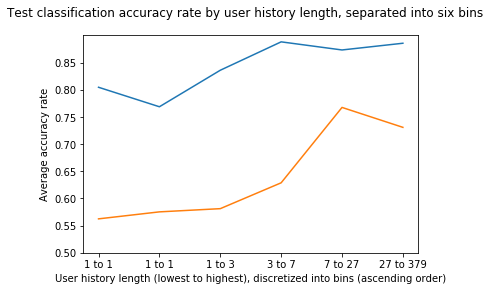

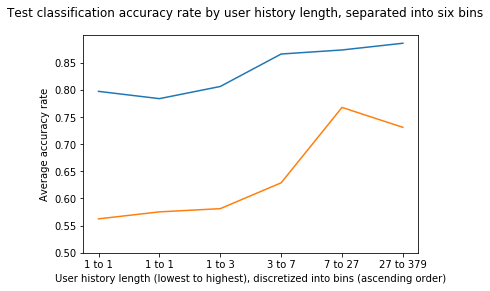

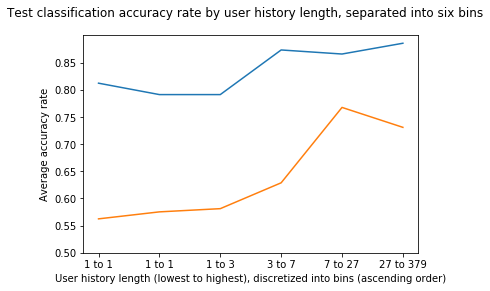

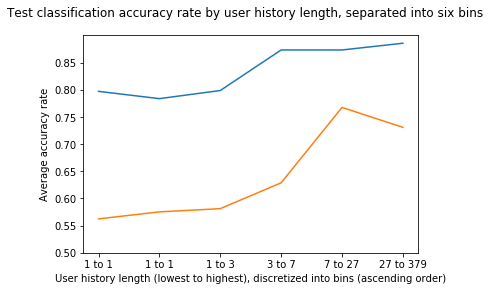

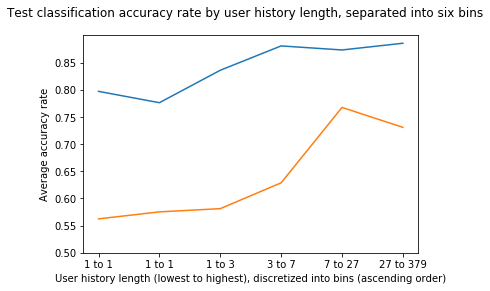

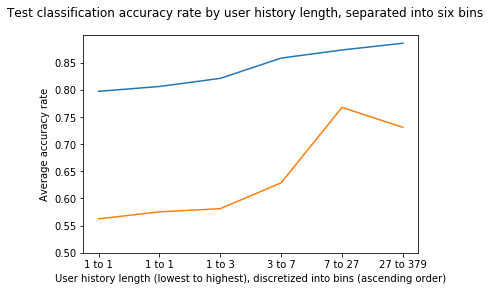

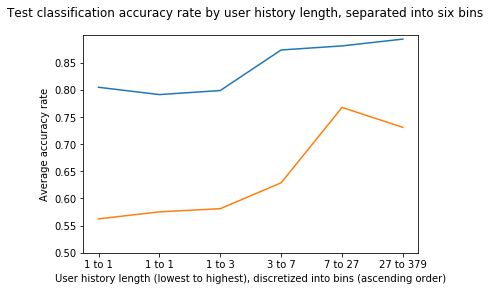

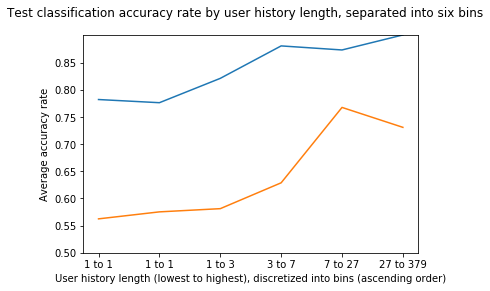

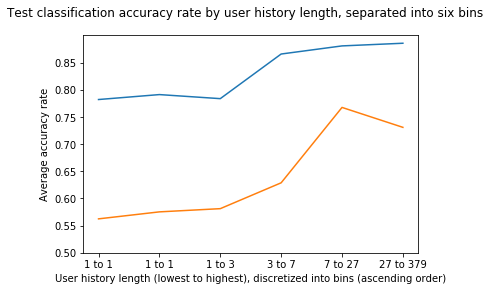

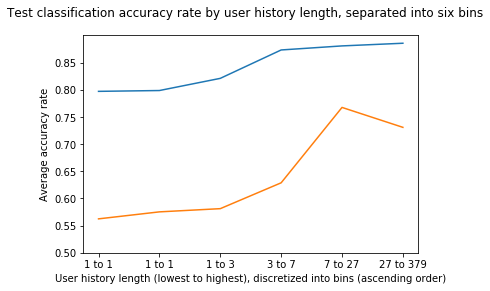

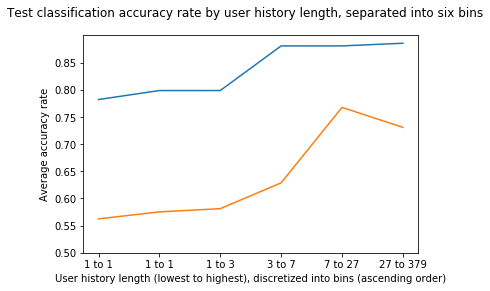

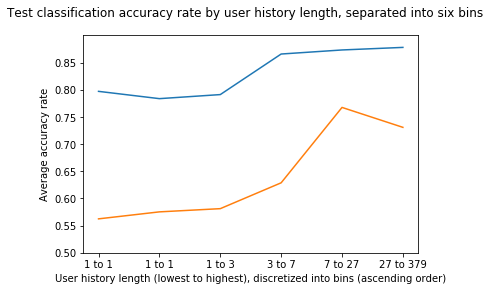

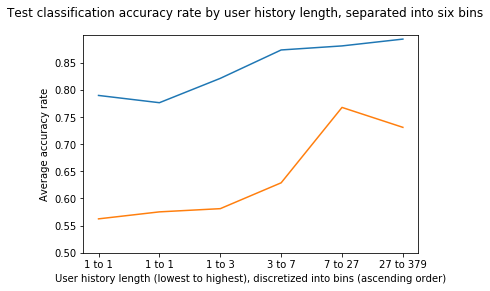

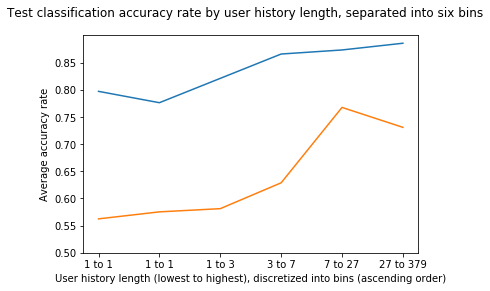

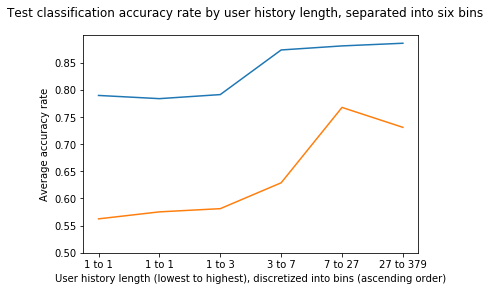

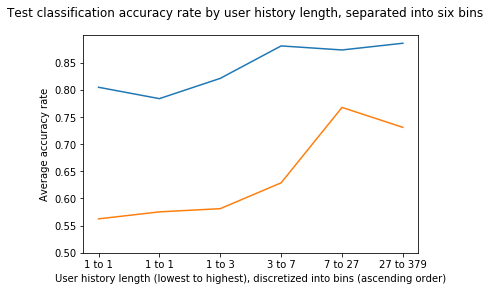

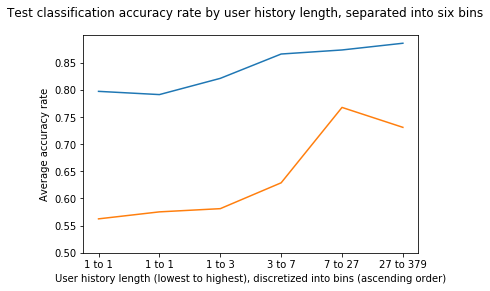

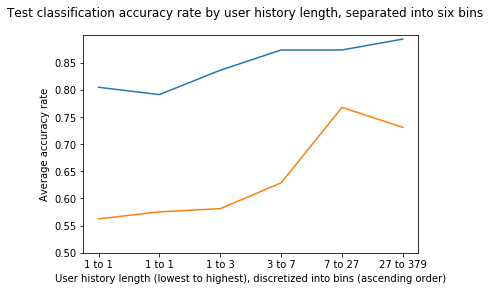

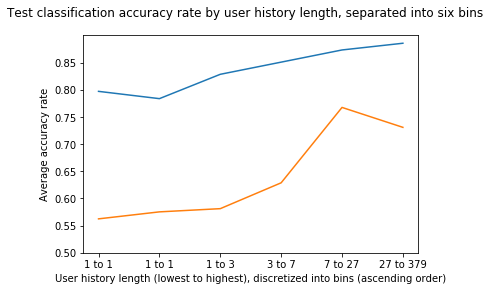

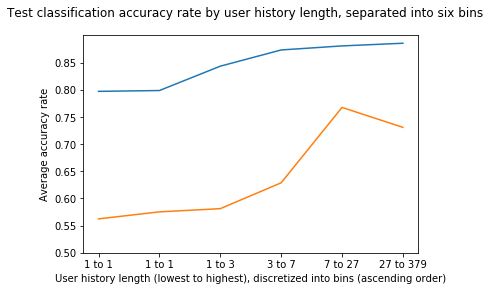

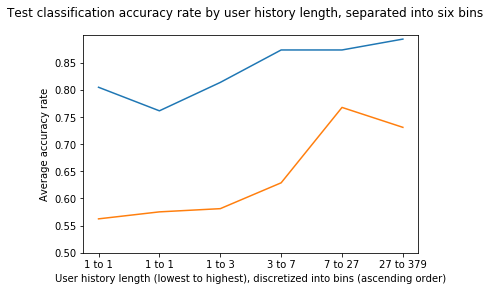

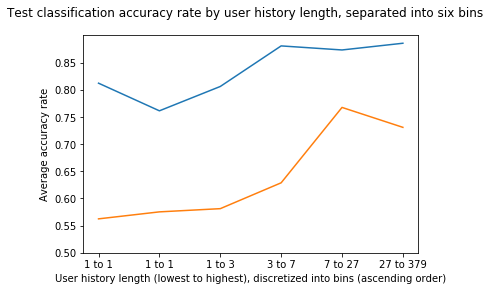

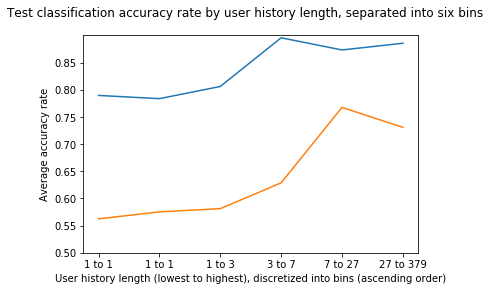

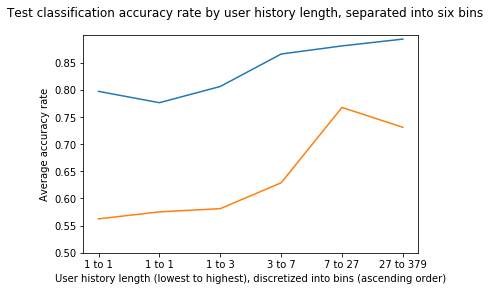

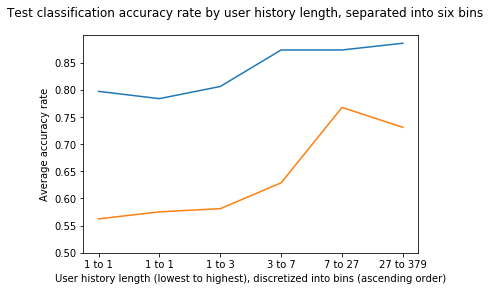

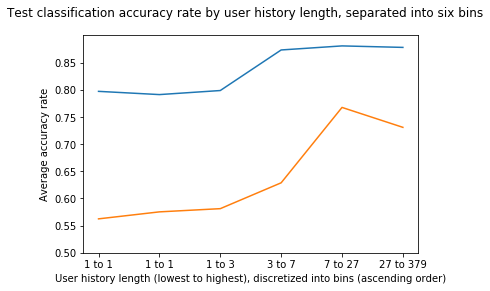

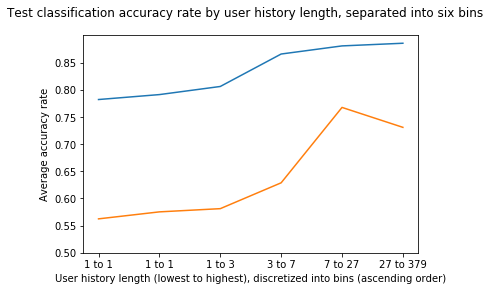

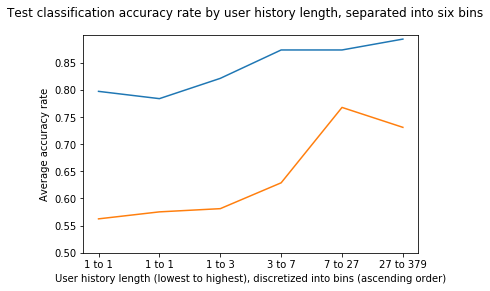

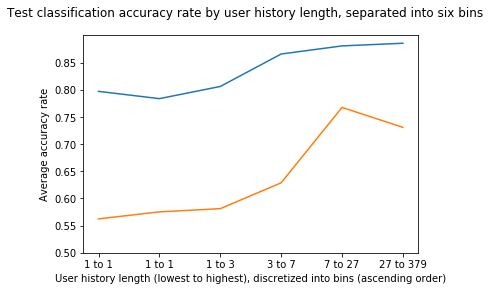

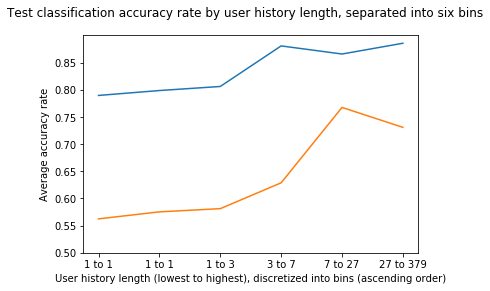

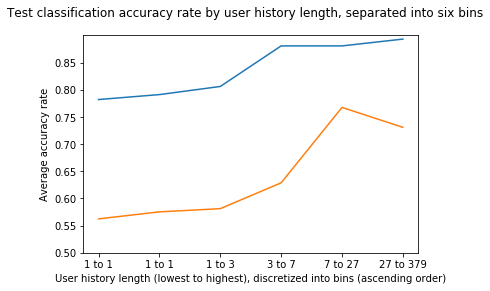

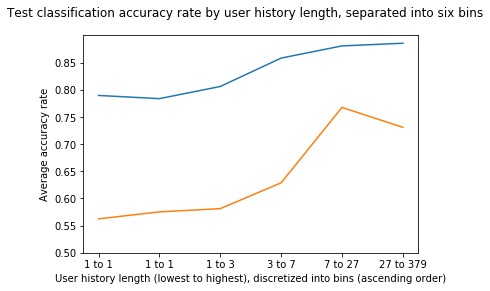

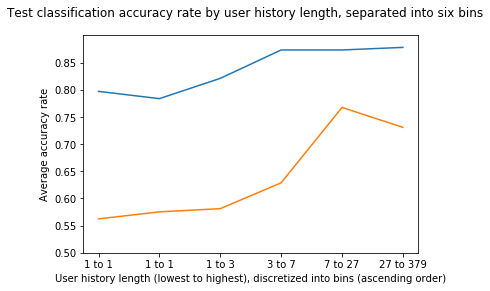

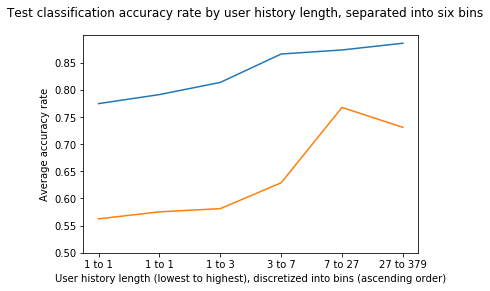

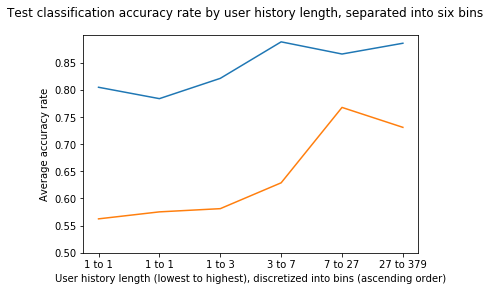

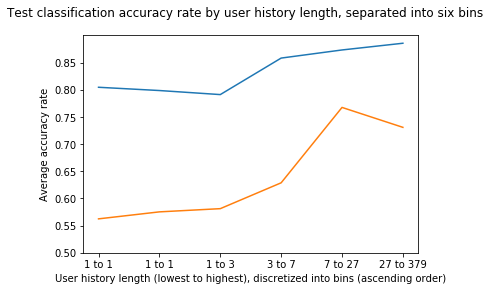

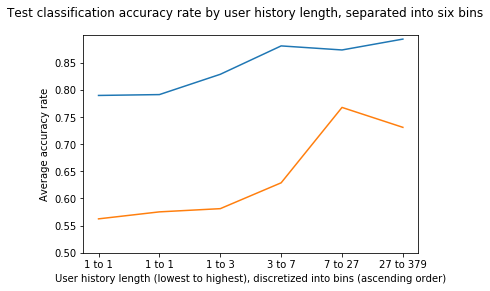

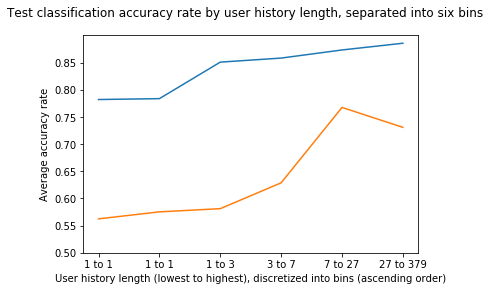

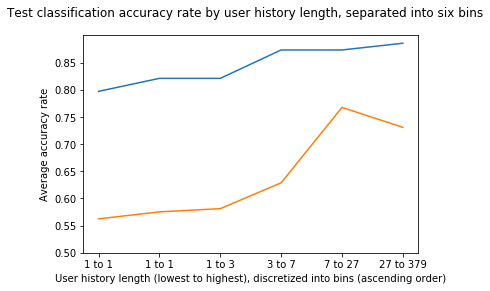

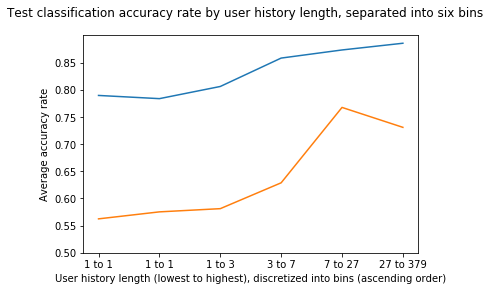

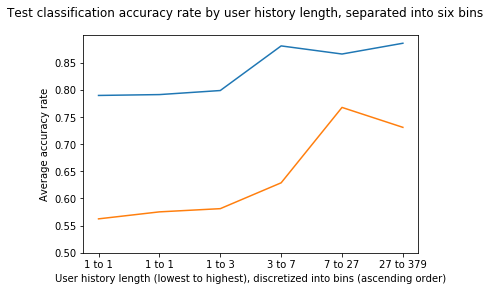

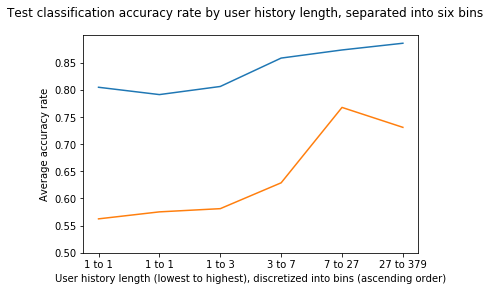

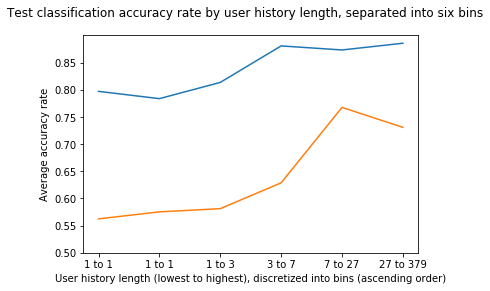

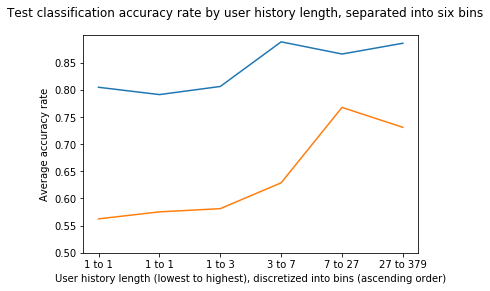

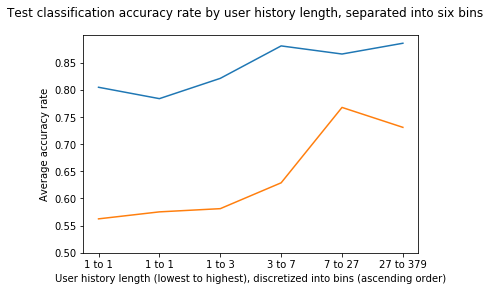

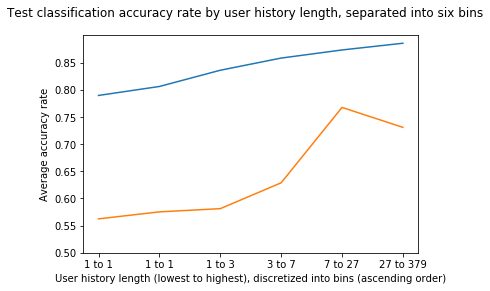

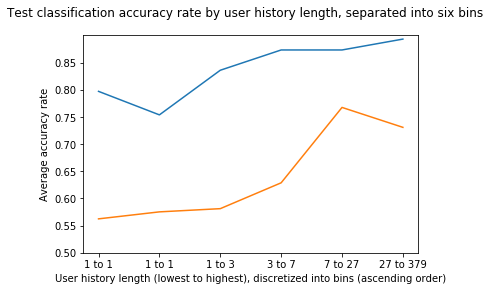

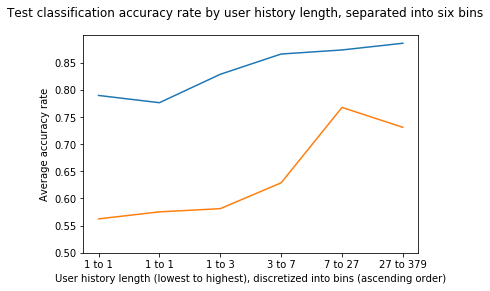

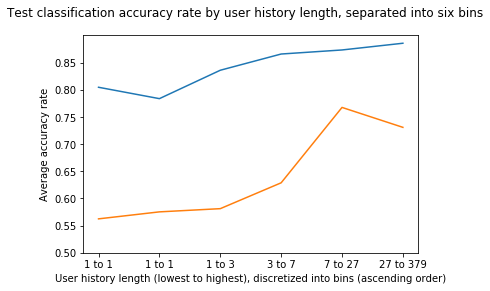

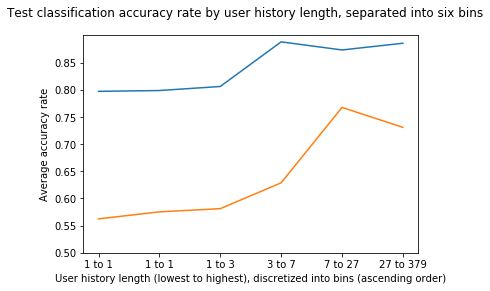

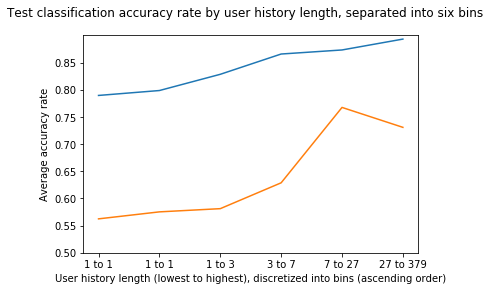

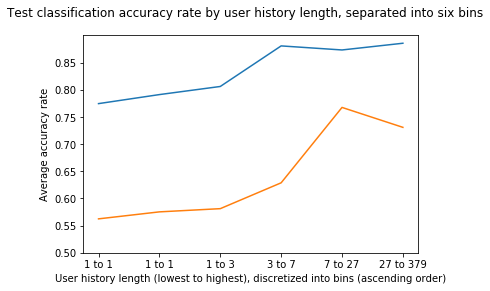

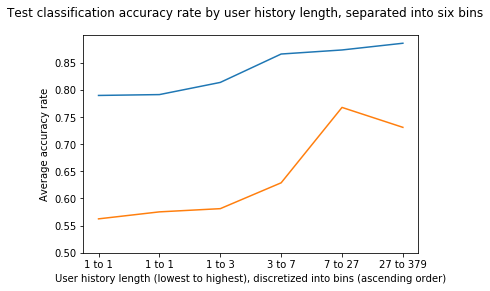

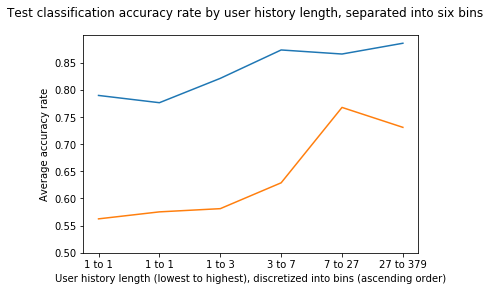

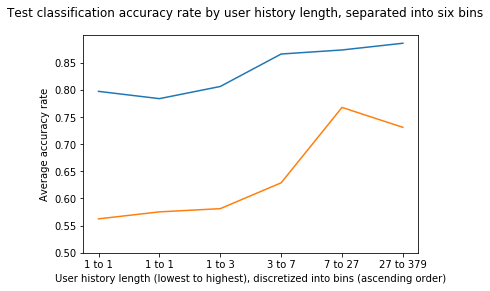

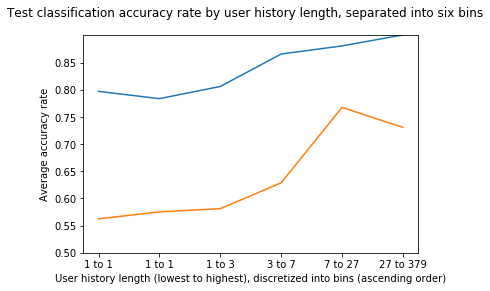

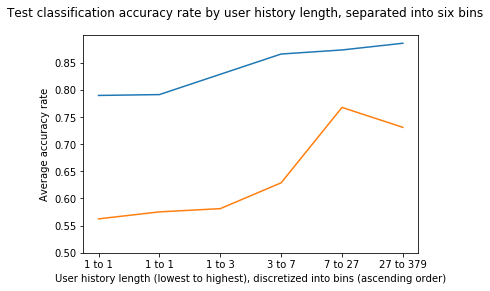

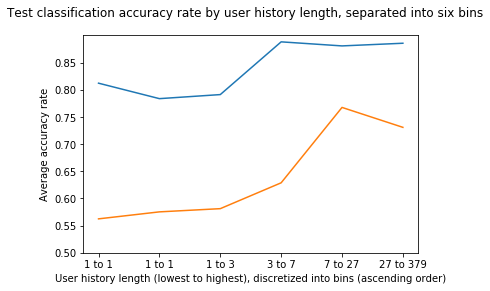

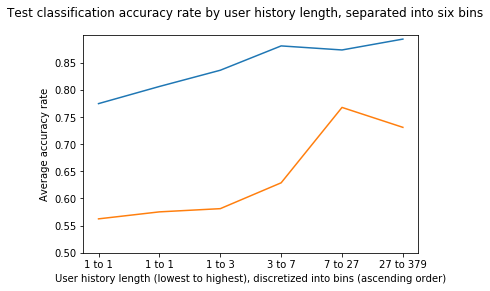

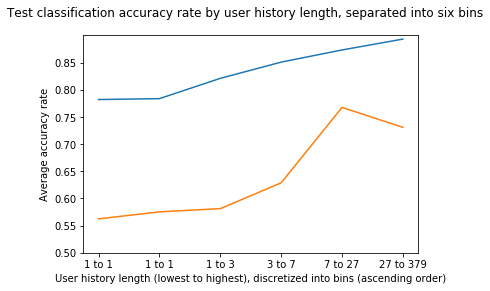

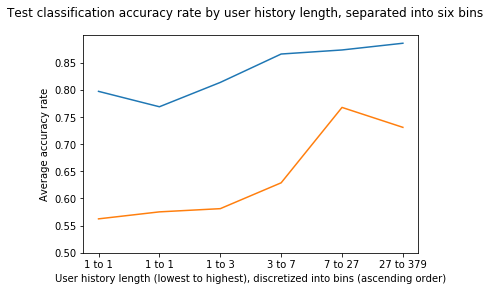

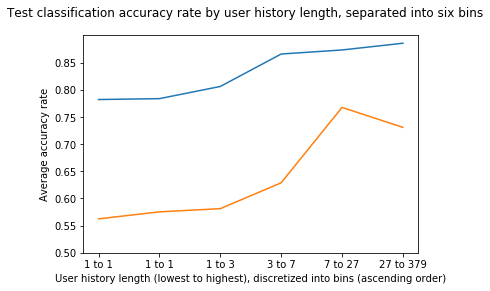

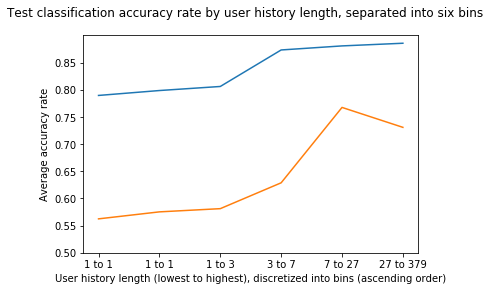

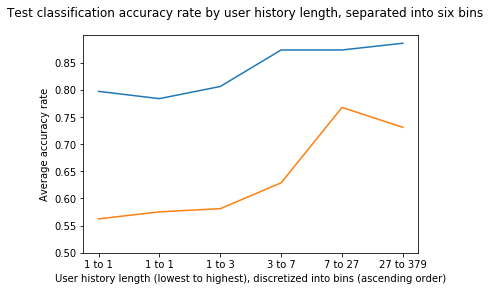

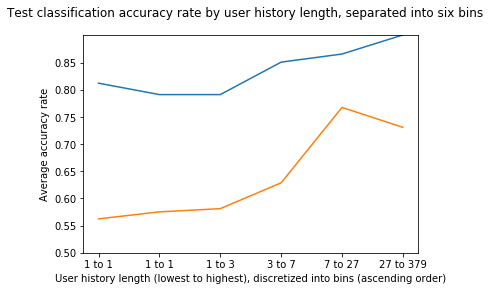

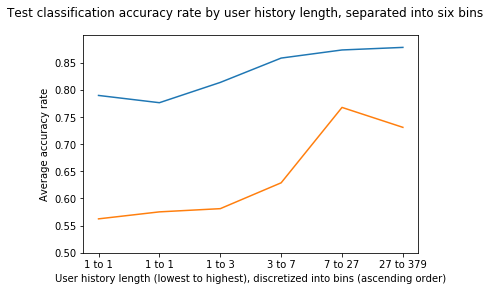

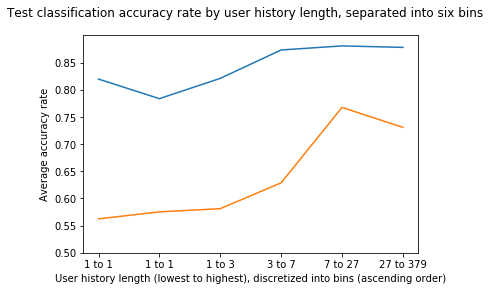

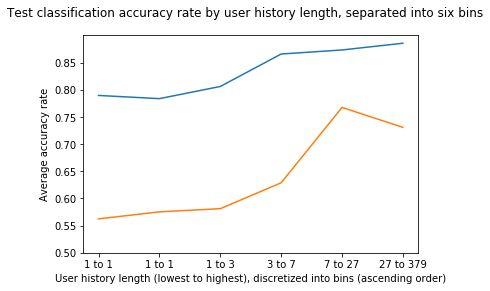

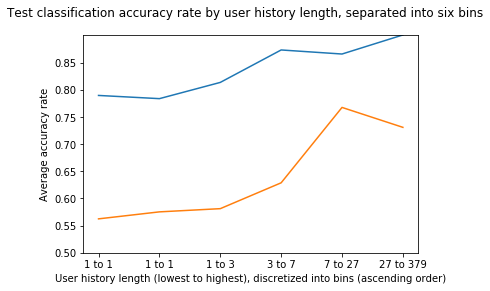

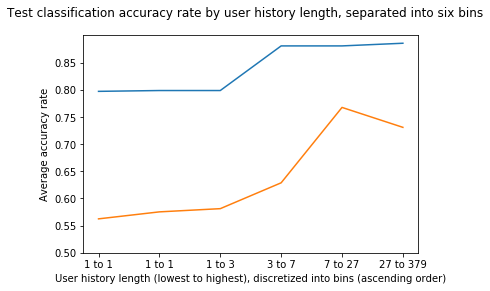

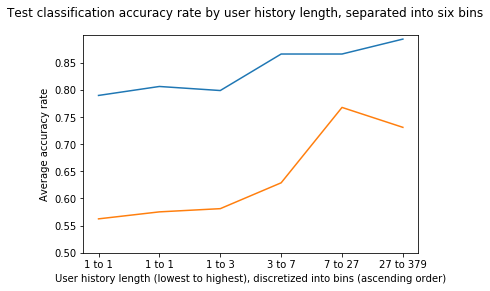

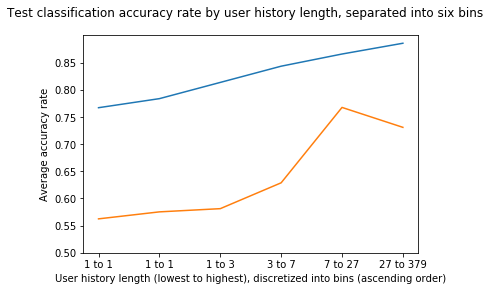

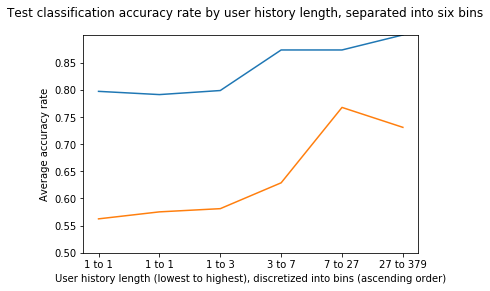

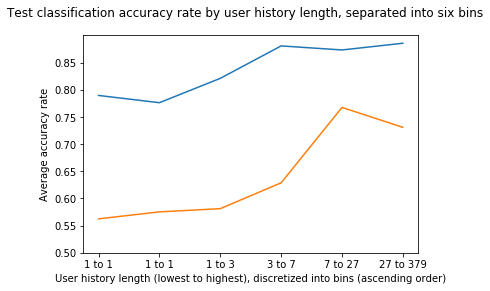

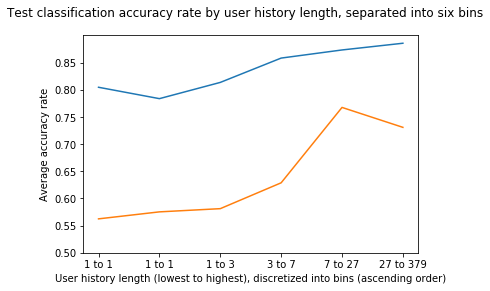

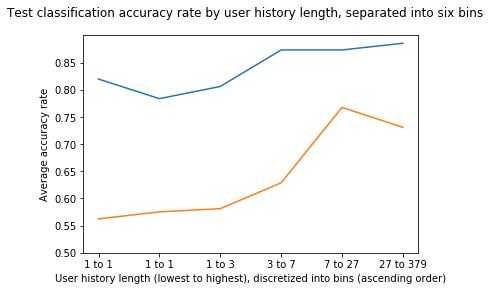

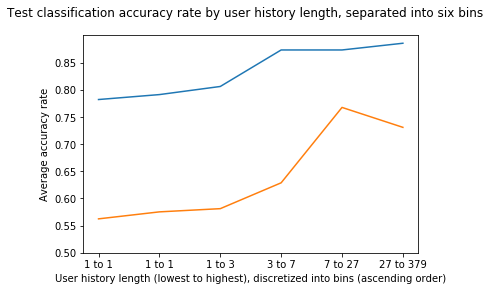

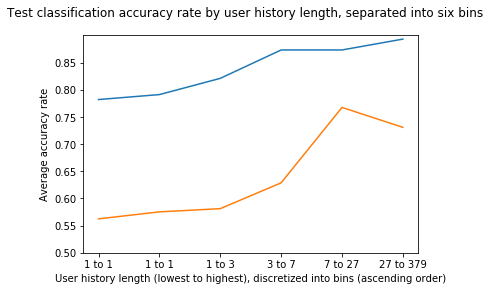

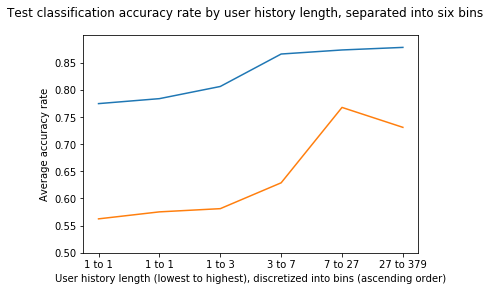

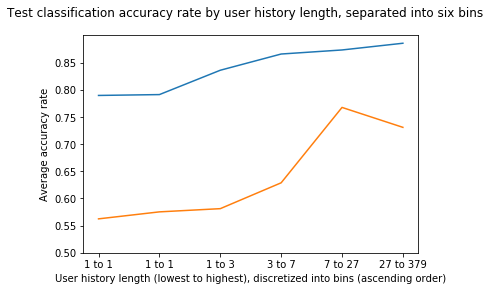

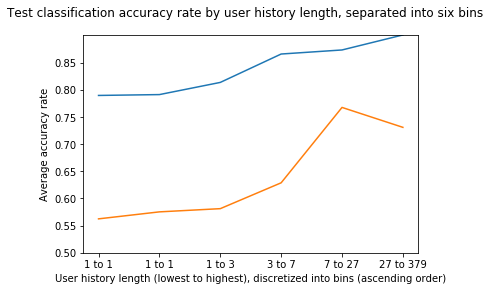

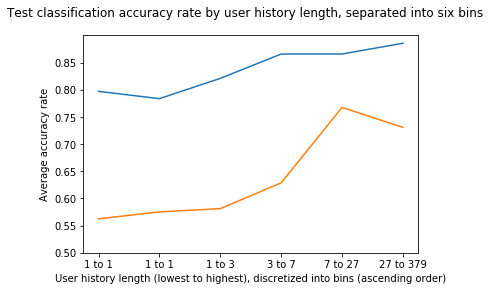

In [14]:


acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

0.8372250000000004
0.84012919820246


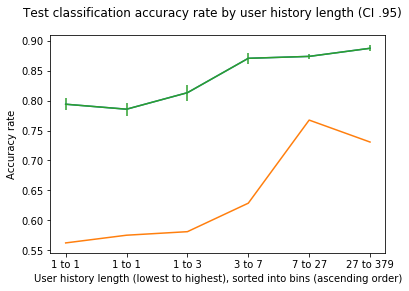

In [15]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

